In [3]:
## ---- Global Doublelet Methods Comparison---- 0688.00.00
##
## Load Analysis Parameters (Parm1)
## Load The Downsampled CDS Object
## Load the Scrublet Results (Scores and Marked Cells)
## Load the DoubletDecon Results (Doubled Marked Cells)
## Load the Gene Exclusion Remix and Doublet Results
## Annotate the Three Doublet Methods into the CDS Object
## Perform Comparisons of Doublet Methods

In [2]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
# library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(corpcor)
library(fdrtool)
library(repr)

In [2]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [3]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

## Read the cell data sets

In [8]:
## Read the remix cell barcodes and cluster name/mappings
remix_codes <- read.table('outputdat/Remix_Codes.Rev1.txt', header = FALSE, stringsAsFactors = FALSE)

In [9]:
## Read the saved the baseline cell data set (downsampled and tagged)
down_stdycds <- readRDS(paste(ps$outdir, 'GeneExcl/',
        'Aggregated.downsampled.Baseline.Repartitioned.rds', sep = ''))

In [10]:
## Read the saved the baseline cell data set (downsampled and tagged)
down_stdycds_rem <- readRDS(paste(ps$outdir,
        'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [11]:
dim(down_stdycds_rem)

[1] 24318 13070

## Gene Exclusion Summary Reporting

In [9]:
## Fead the Gene Exclusion Doublet Method Associated Barcodes
down_bar <- read.table(paste(ps$outdir, 'GeneExcl/Rev1/Baseline.Cells.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)
GE_BL_rmDB_rmQC_bar <- read.table( paste(ps$outdir, 'GeneExcl/Rev1/Baseline.rmQC.rmDoublet.Cells.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)
GE_DB_bar <- read.table(paste(ps$outdir, 'GeneExcl/Rev1/Baseline.Doublet.Cells.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)
GE_QC_bar <-read.table(paste(ps$outdir, 'GeneExcl/Rev1/Baseline.QC.Cells.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)
GE_BL_rmQC_bar <- read.table(paste(ps$outdir, 'GeneExcl/Rev1/Baseline.rmQC.Cells.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)

In [10]:
GE_BL_rmDB_rmQC_bar_s <- which(down_bar[,1] %in% GE_BL_rmDB_rmQC_bar[,1])
colData(down_stdycds)$GE_Final <- FALSE
colData(down_stdycds)$GE_Final[GE_BL_rmDB_rmQC_bar_s] <- TRUE

GE_DB_bar_s <- which(down_bar[,1] %in% GE_DB_bar[,1])
colData(down_stdycds)$GE_DB <- FALSE
colData(down_stdycds)$GE_DB[GE_DB_bar_s] <- TRUE

GE_QC_bar_s <- which(down_bar[,1] %in% GE_QC_bar[,1])
colData(down_stdycds)$GE_QC <- FALSE
colData(down_stdycds)$GE_QC[GE_QC_bar_s] <- TRUE

GE_BL_rmQC_bar_s <- which(down_bar[,1] %in% GE_BL_rmQC_bar[,1])
colData(down_stdycds)$GE_rmQC <- FALSE
colData(down_stdycds)$GE_rmQC[GE_BL_rmQC_bar_s] <- TRUE

In [11]:
## Create remixed cell set with QC failed cells removed, and get barcodes as well
down_stdycds_rmQC <- down_stdycds[, GE_BL_rmQC_bar_s]
down_bar_rmQC <- colnames(down_stdycds_rmQC)

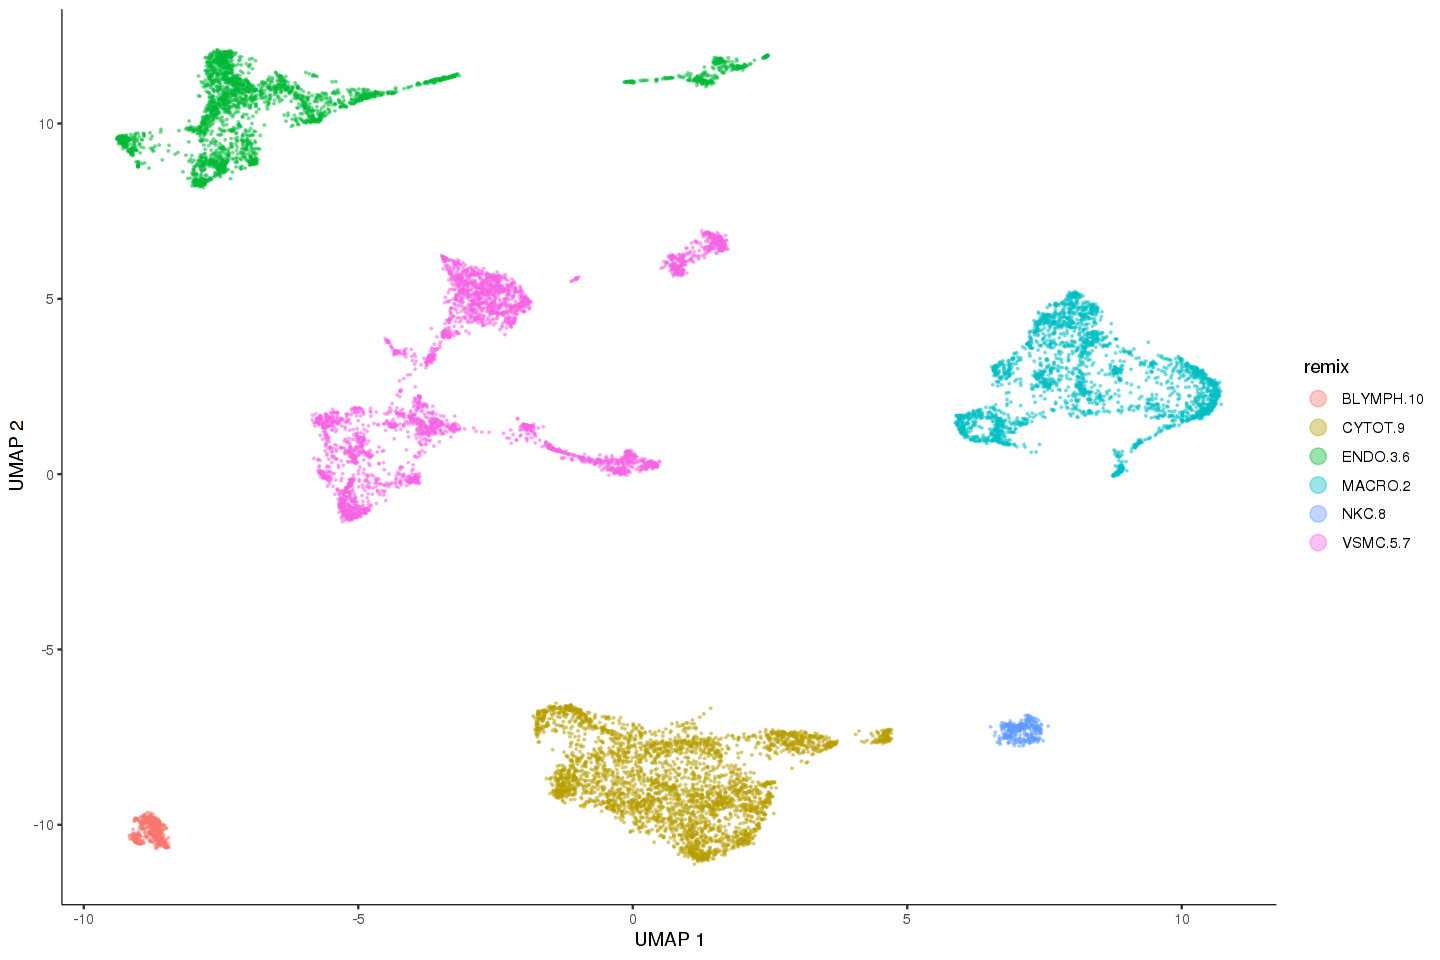

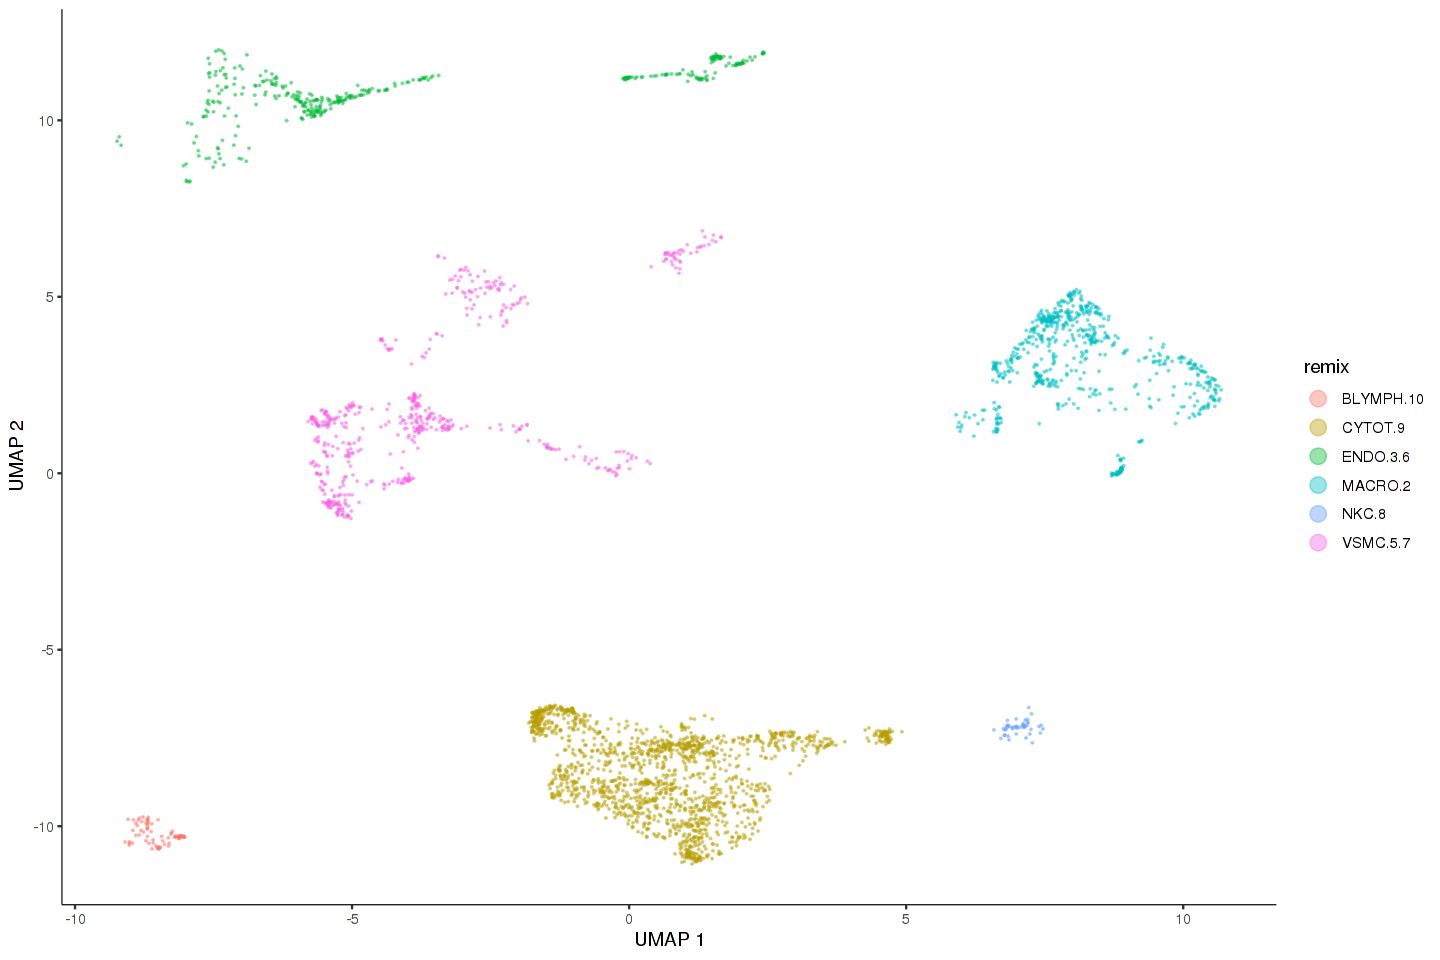

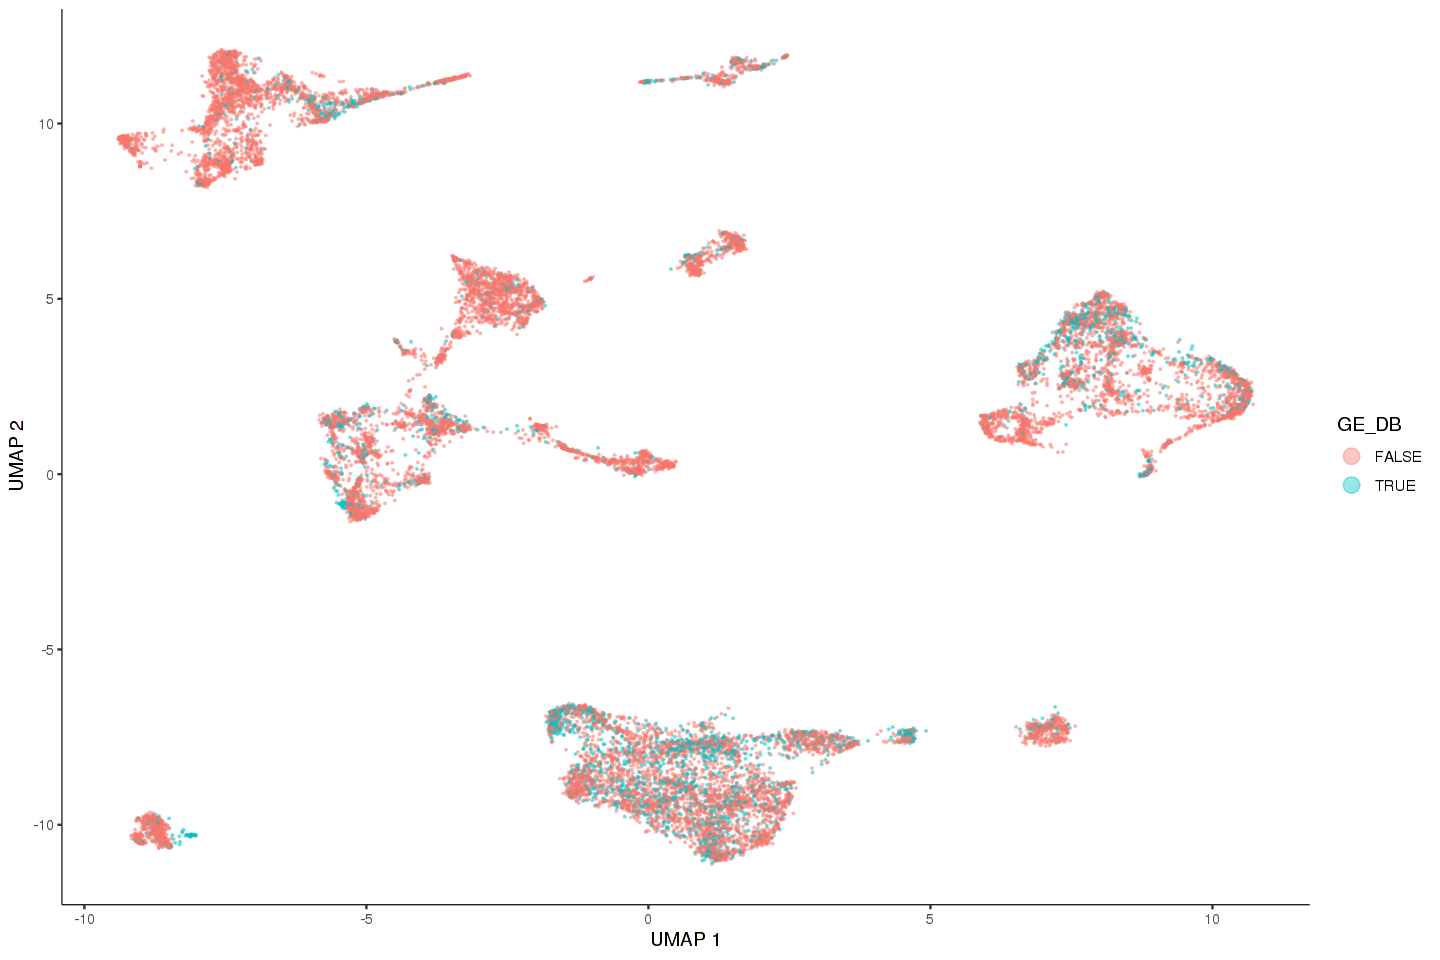

In [14]:
## Plot the remixed partitions, then doublet cells only in the remixed partitions,
## and then remixed partitions colorized by doublets
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow=c(3,1))
plot_cells(down_stdycds[, GE_BL_rmDB_rmQC_bar_s], color_cells_by = "remix", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
plot_cells(down_stdycds[, GE_DB_bar_s], color_cells_by = "remix", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
plot_cells(down_stdycds[,GE_BL_rmQC_bar_s], color_cells_by = "GE_DB", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)

## Scrublet Summary Reporting

In [12]:
## Read the Scrublet Results
Scrub_bar <- substr(read.table( paste(ps$outdir, 'Scrublet/Rev2/remix.keepers.10pct.Rev2.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)[,1], 3, 20)
Scrub_bar2 <- substr(read.table( paste(ps$outdir, 'Scrublet/Rev2/remix.barcodes.10pct.Rev2.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)[,1], 3, 20)
Scrub_bar3 <- read.table( paste(ps$outdir, 'Scrublet/Rev2/remix.keepers2.10pct.Rev2.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)[,1]
Scrub_DB_i <- read.table( paste(ps$outdir, 'Scrublet/Rev2/predicted_doublets.10pct.Rev2.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)
Scrub_score <- read.table(paste(ps$outdir, 'Scrublet/Rev2/doublet_scores.10pct.Rev2.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE)[,1]
Scrub_umap <- read.table( paste(ps$outdir, 'Scrublet/Rev2/remix.umap.10pct.Rev2.txt', sep = ''),
            header = FALSE, stringsAsFactors = FALSE, sep = ',')

rownames(Scrub_umap) <- Scrub_bar3
Scrub_umap <- cbind(Scrub_umap, c('NO', 'YES')[1 + Scrub_DB_i[,]], Scrub_score)
colnames(Scrub_umap) <- c('x', 'y', 'dblt', 'score')

In [13]:
## Create colData marking the Scrublet doublet (TRUE or FALSE)
## in Remixed cells set with QC failed cells removed
Scrub_DB_bar <- Scrub_bar3[which(Scrub_DB_i[,] == 1)]
Scrub_DB_s <- which(down_bar_rmQC %in% Scrub_DB_bar)
colData(down_stdycds_rmQC)$Scrub_DB <- FALSE
colData(down_stdycds_rmQC)$Scrub_DB[Scrub_DB_s] <- TRUE

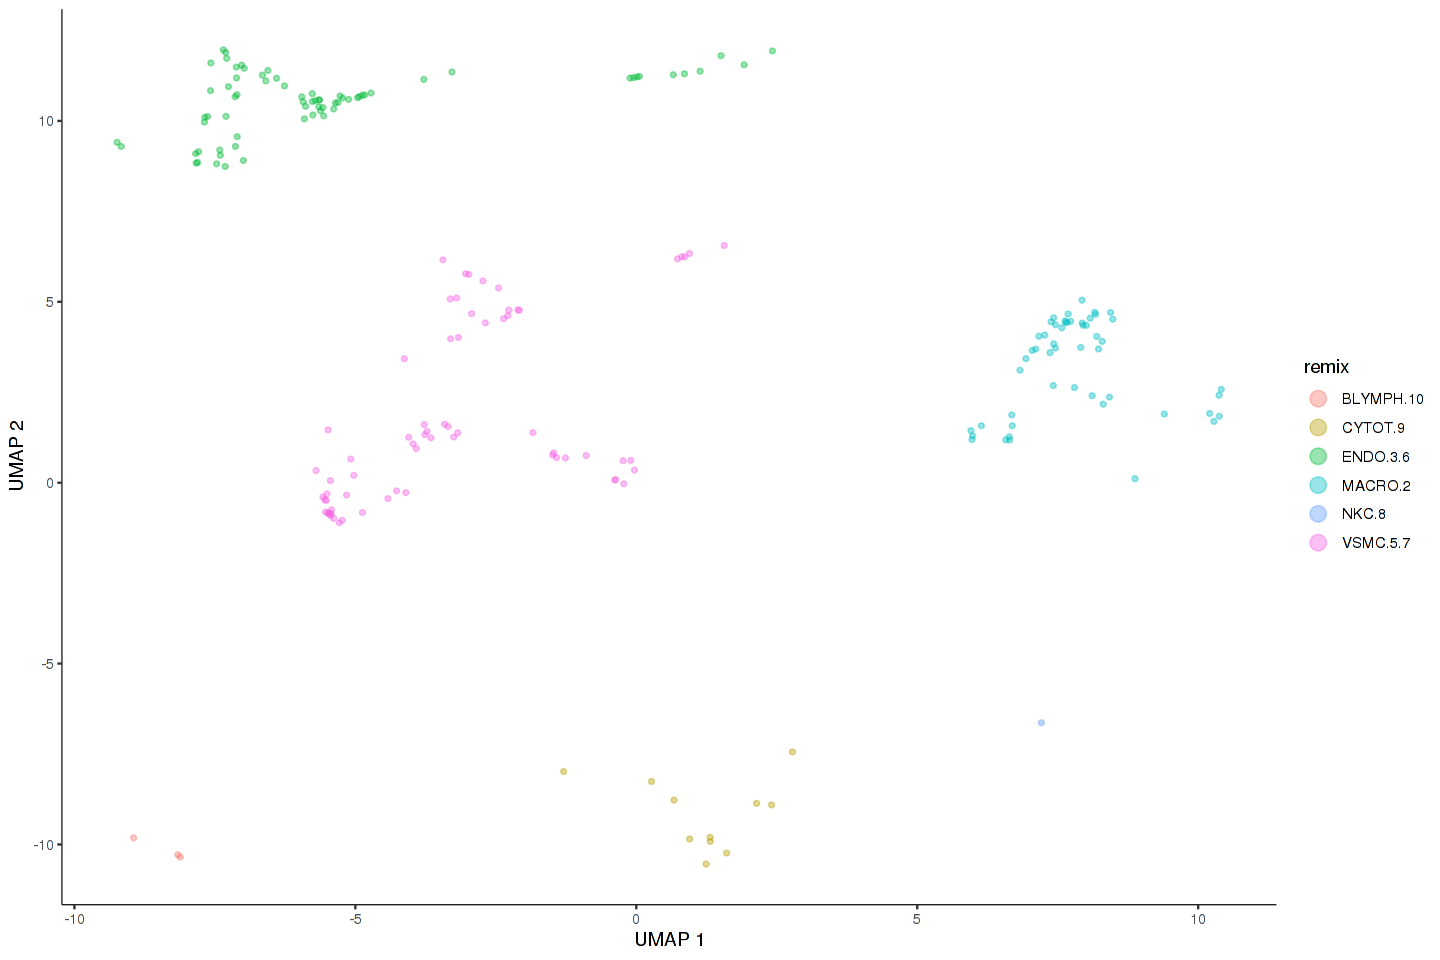

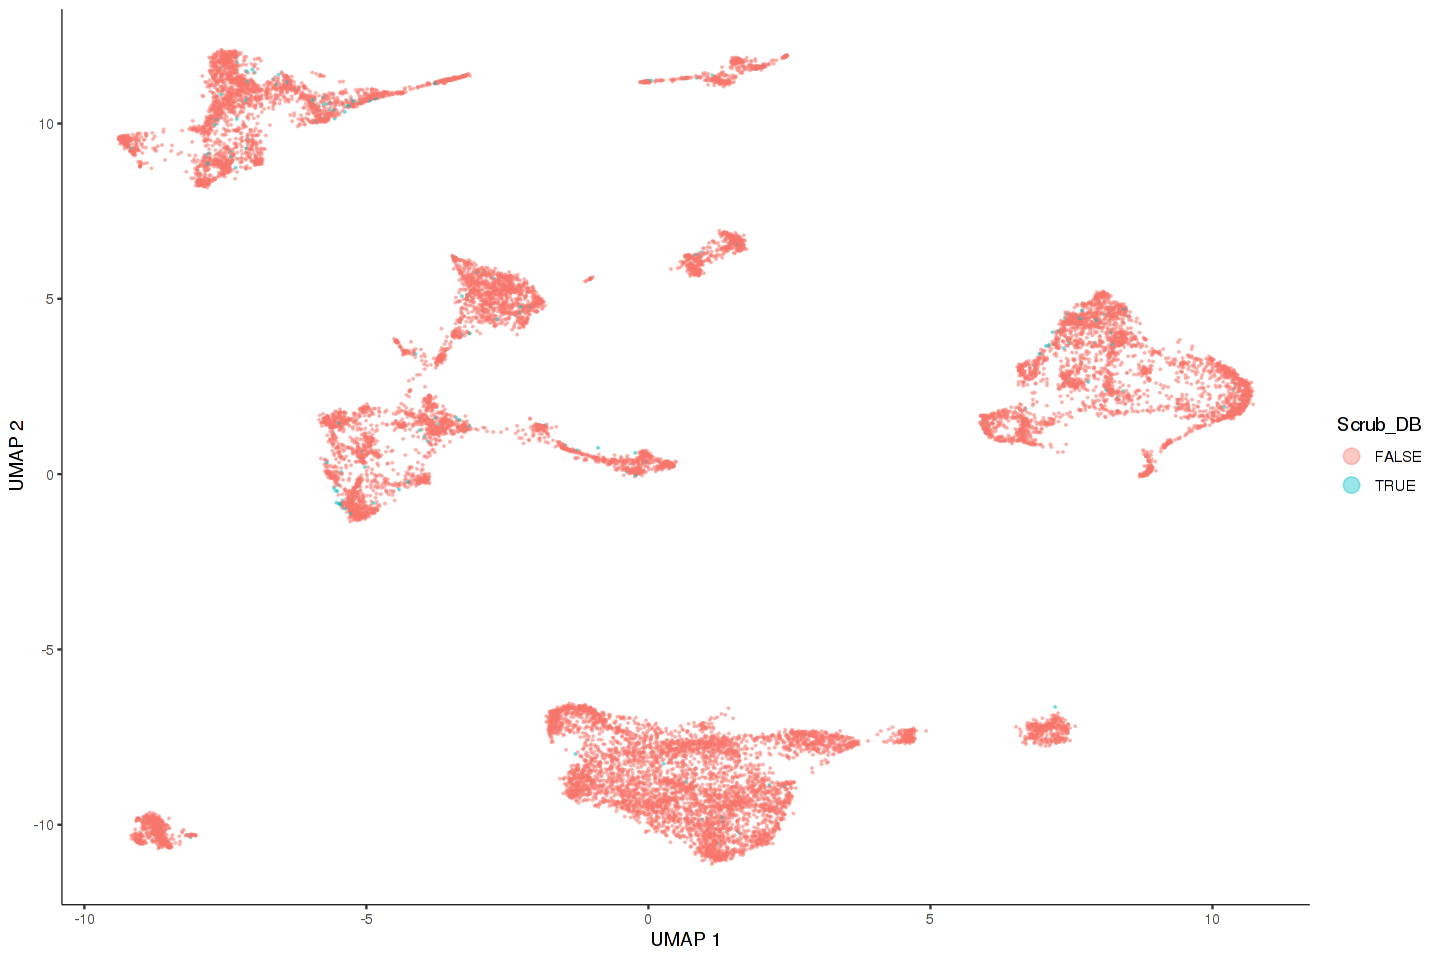

In [60]:
## Plot Scrublet Doublets and all cells colorized by Doublet Using Monocle UMAP Embedding
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow=c(2,1))
plot_cells(down_stdycds_rmQC[, Scrub_DB_s], color_cells_by = "remix", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 1, alpha = .4)
plot_cells(down_stdycds_rmQC, color_cells_by = "Scrub_DB", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)

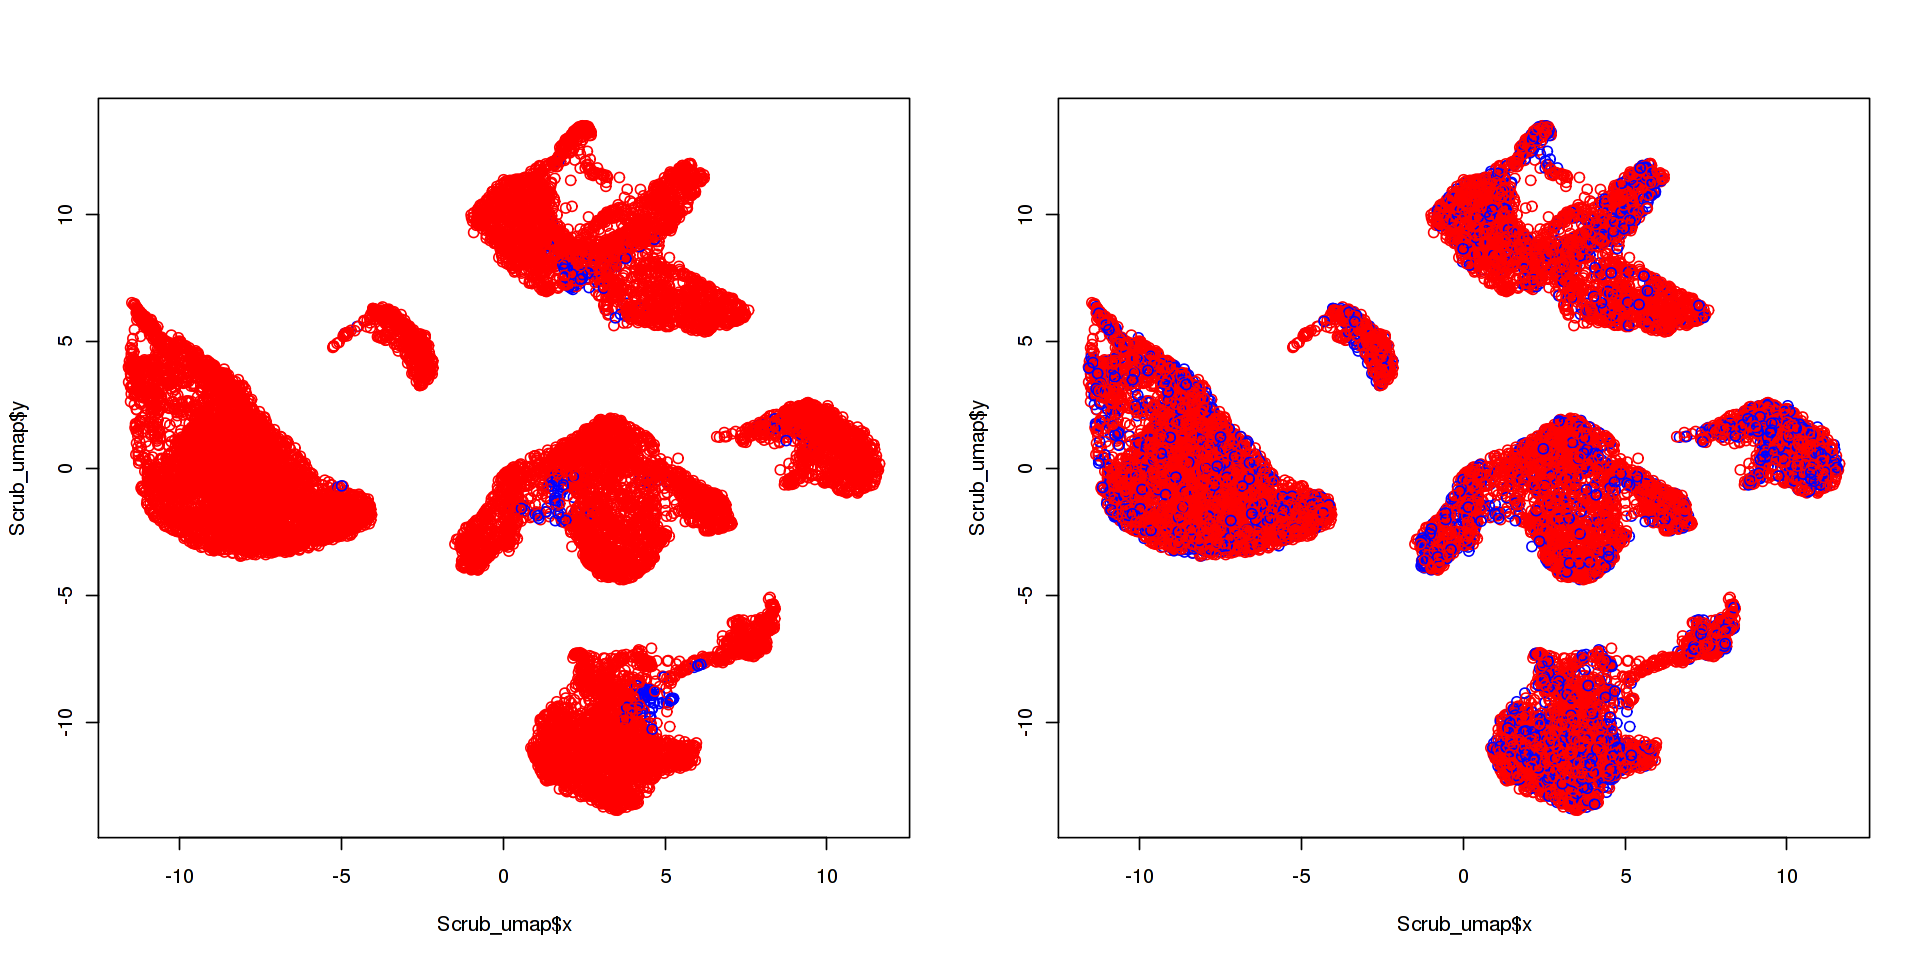

In [61]:
## Plot the Scrublet results using the Scrublet UMAP embedding
options(repr.plot.width=16, repr.plot.height=8)
par(mfrow=c(1,2))
plot(Scrub_umap$x, Scrub_umap$y, col = c('red', 'blue')[Scrub_DB_i[, 1] + 1])

## Plot GE Doublets Using Scrublet UMAP embedding
plot(Scrub_umap$x, Scrub_umap$y, col = c('red', 'blue')[colData(down_stdycds[,GE_BL_rmQC_bar_s])$GE_DB * 1 + 1])

In [14]:
## Add Scrublet UMAP embedding to Monocle Cell Set
down_stdycds_rmQC_2 <- down_stdycds_rmQC
rownames(Scrub_umap) <- Scrub_bar3
Scrub_xy <- cbind(Scrub_umap[colnames(down_stdycds_rmQC), 1], Scrub_umap[colnames(down_stdycds_rmQC), 2])
## Remapping (should be the right thing to do, otherwise could use Scrub_umap instead of Scrub_xy
down_stdycds_rmQC_2@reducedDims@listData$UMAP <- cbind(down_stdycds_rmQC@reducedDims@listData$UMAP,
                                                      Scrub_xy)

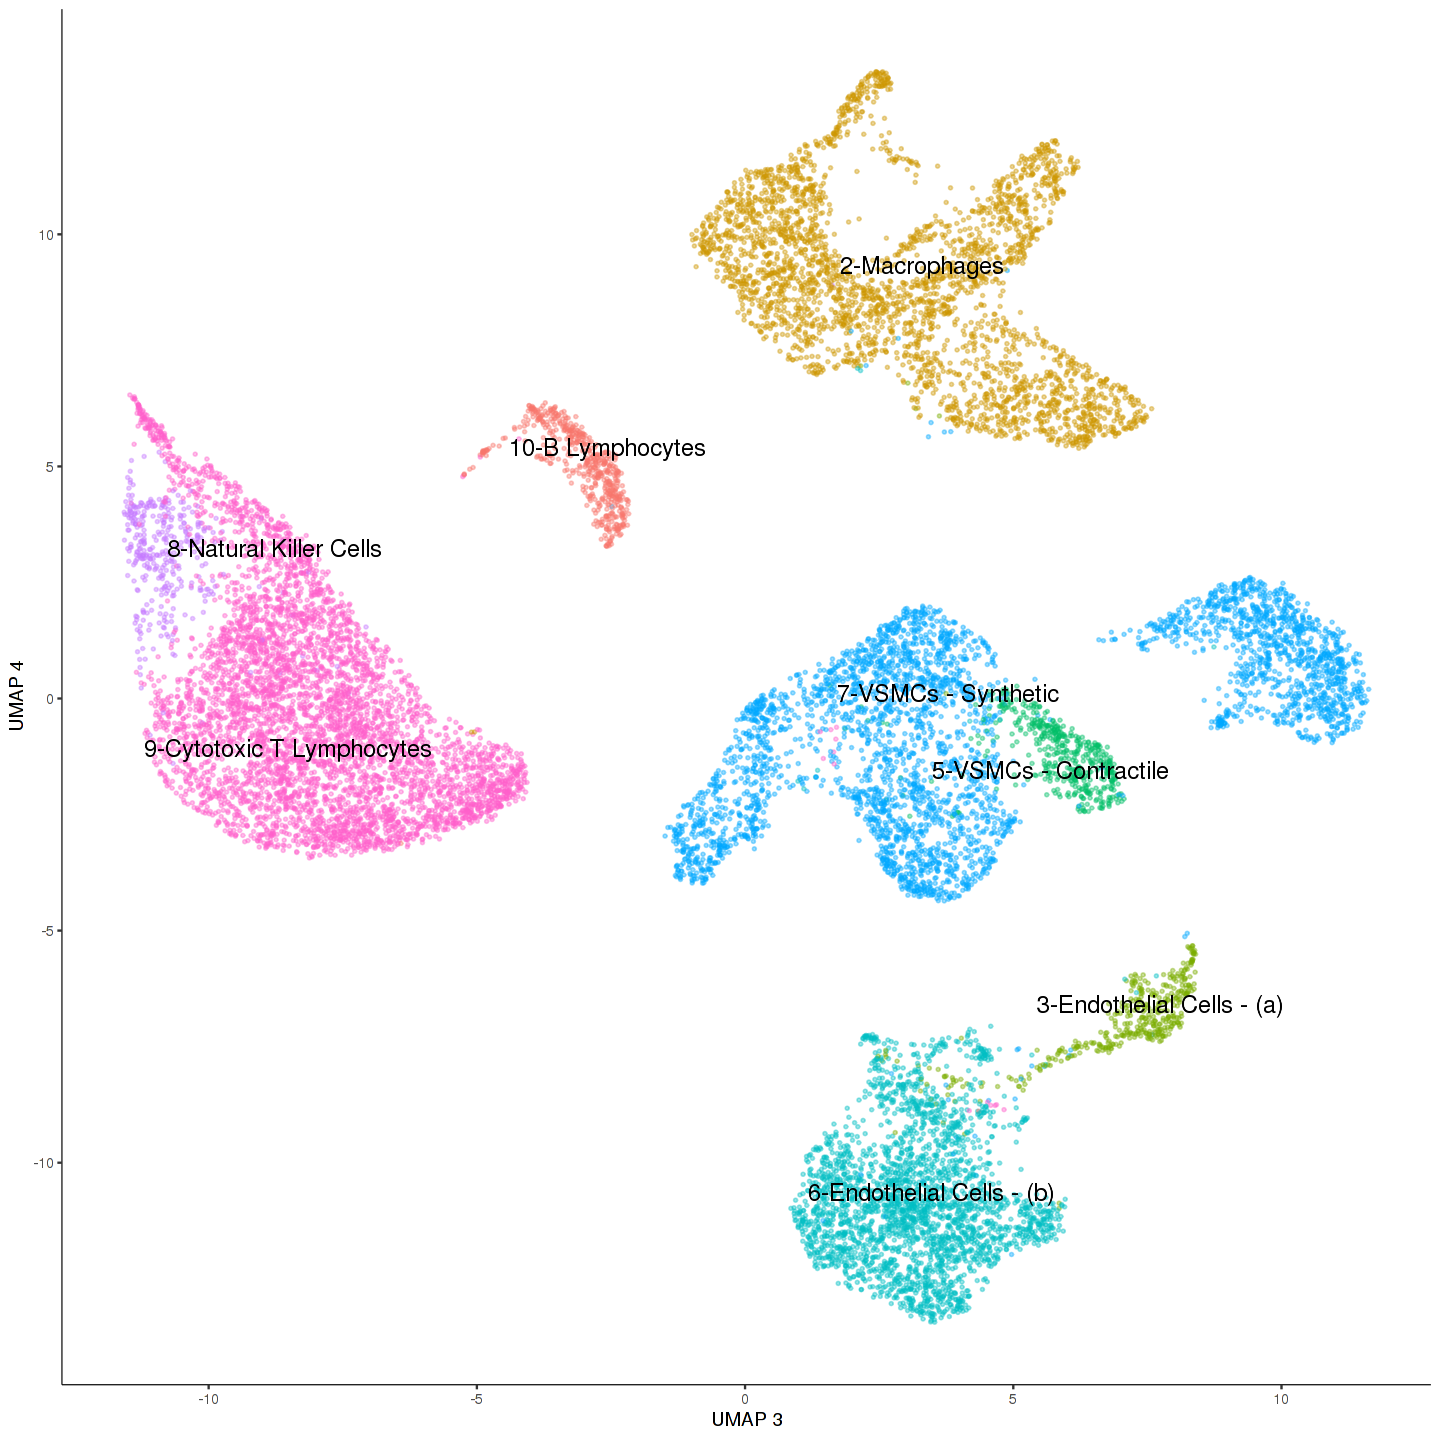

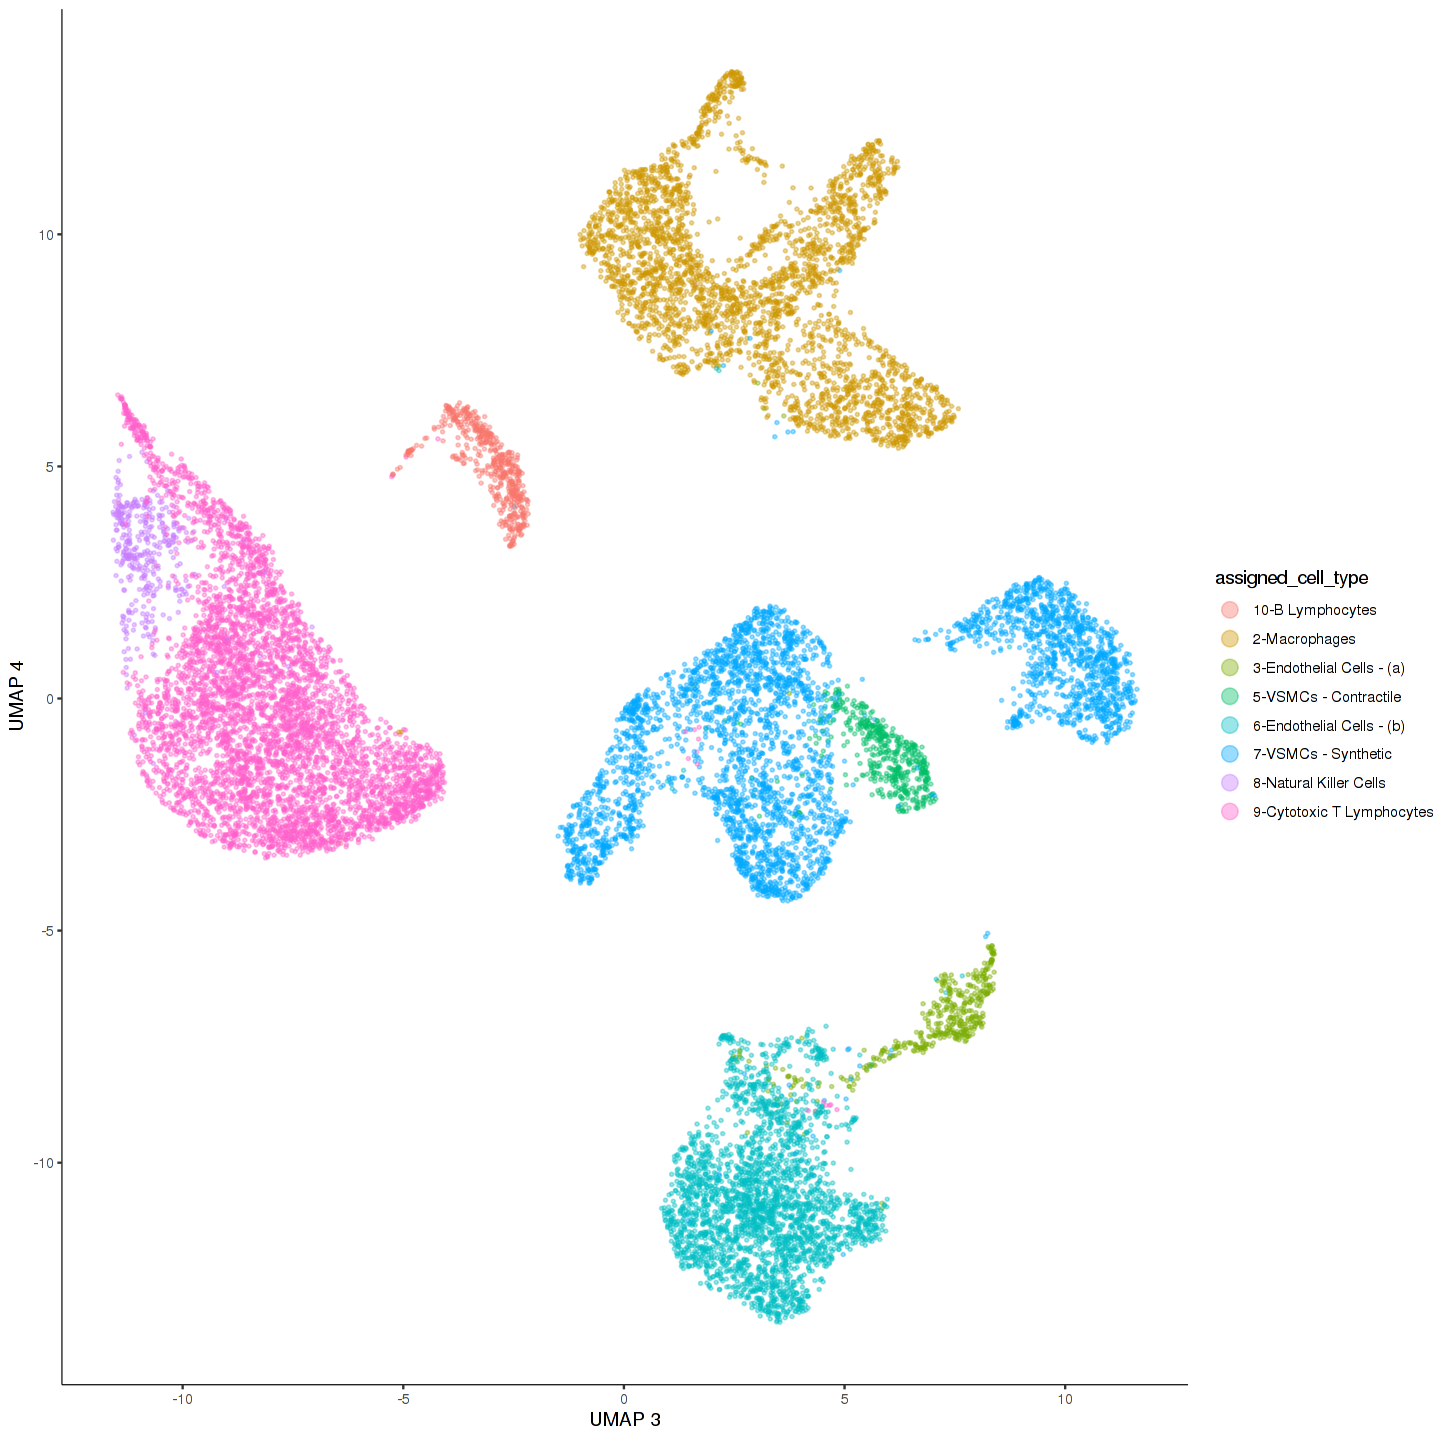

In [63]:
## Plot the Monocle cell set using Scrublet embedding, but using the Monocle clustering as colorization
## This to some degree confirms, more or less, that Scrublet and Monocle UMAP Embedding is Similar
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(2,1))
plot_cells(x = 3, y = 4, down_stdycds_rmQC_2, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = TRUE, group_label_size = 5,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .5, alpha = .4)
plot_cells(x = 3, y = 4, down_stdycds_rmQC_2, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .5, alpha = .4)

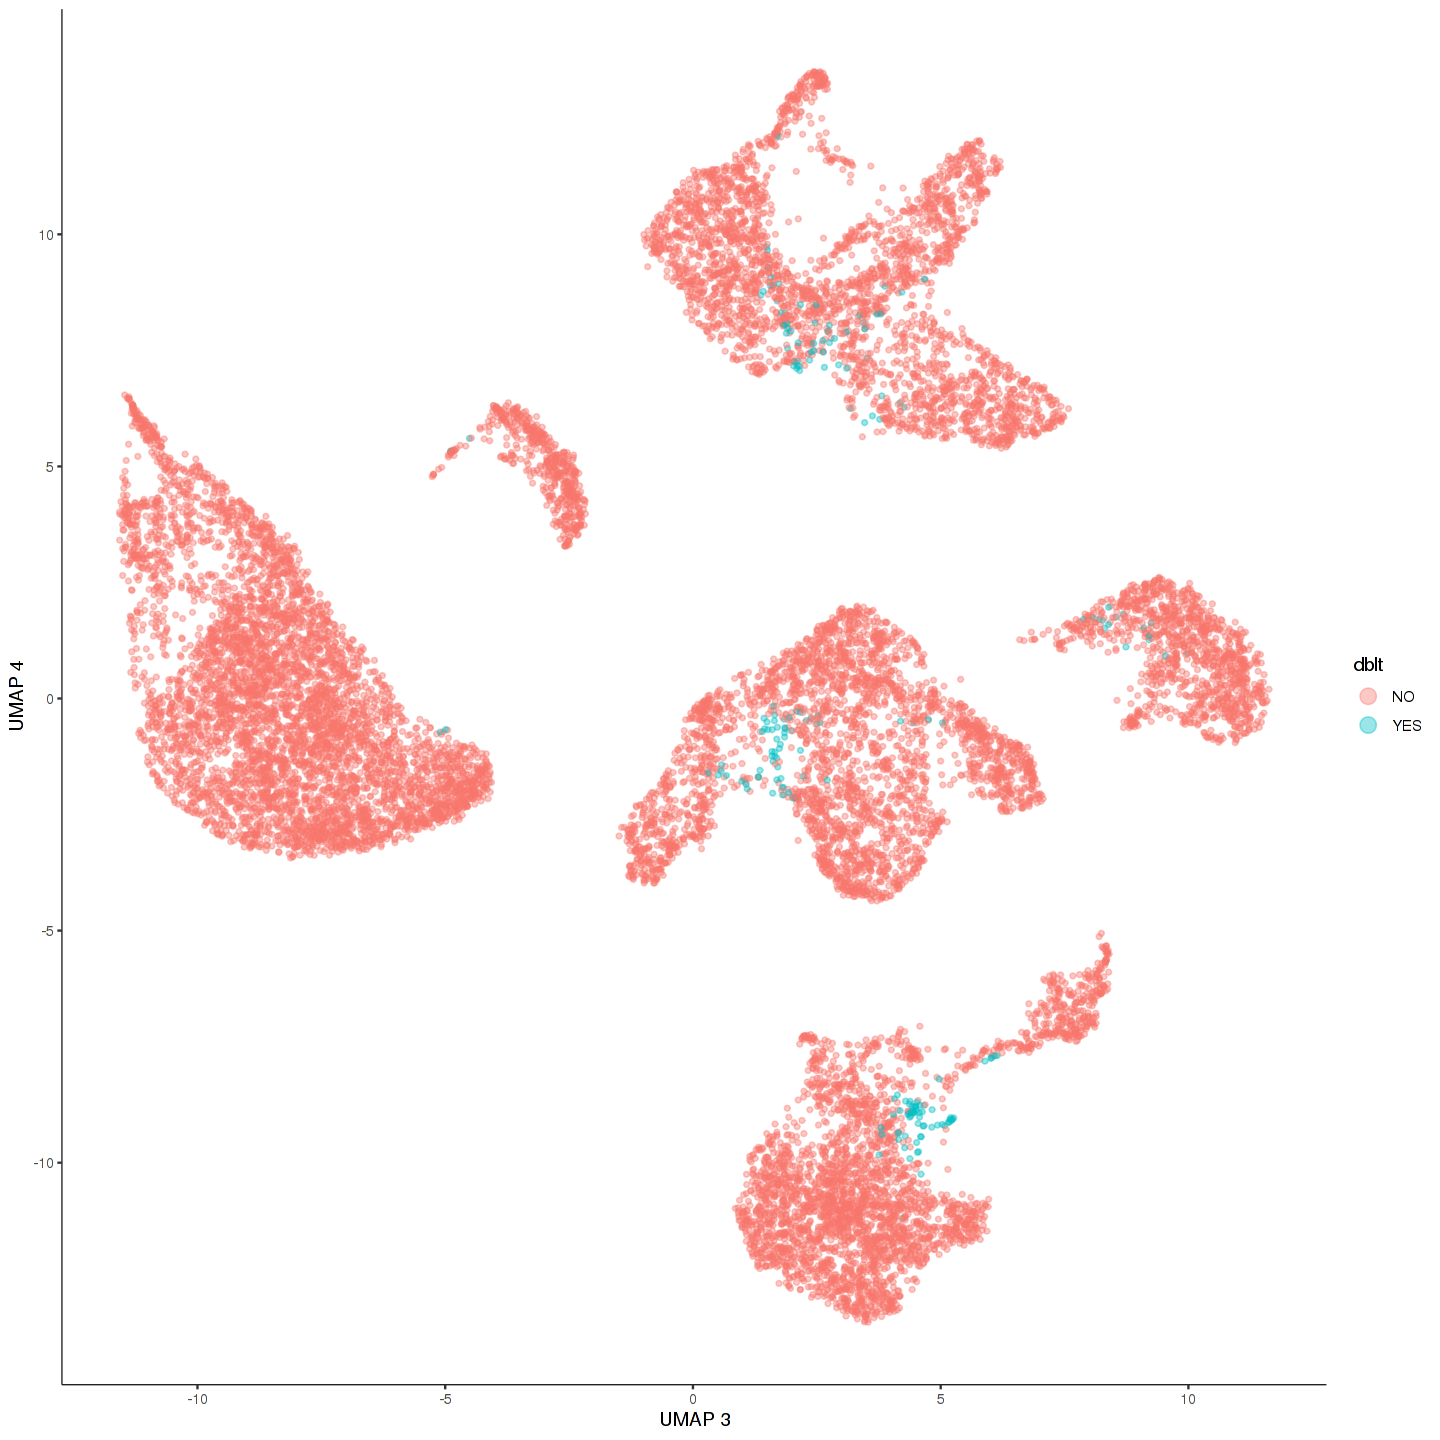

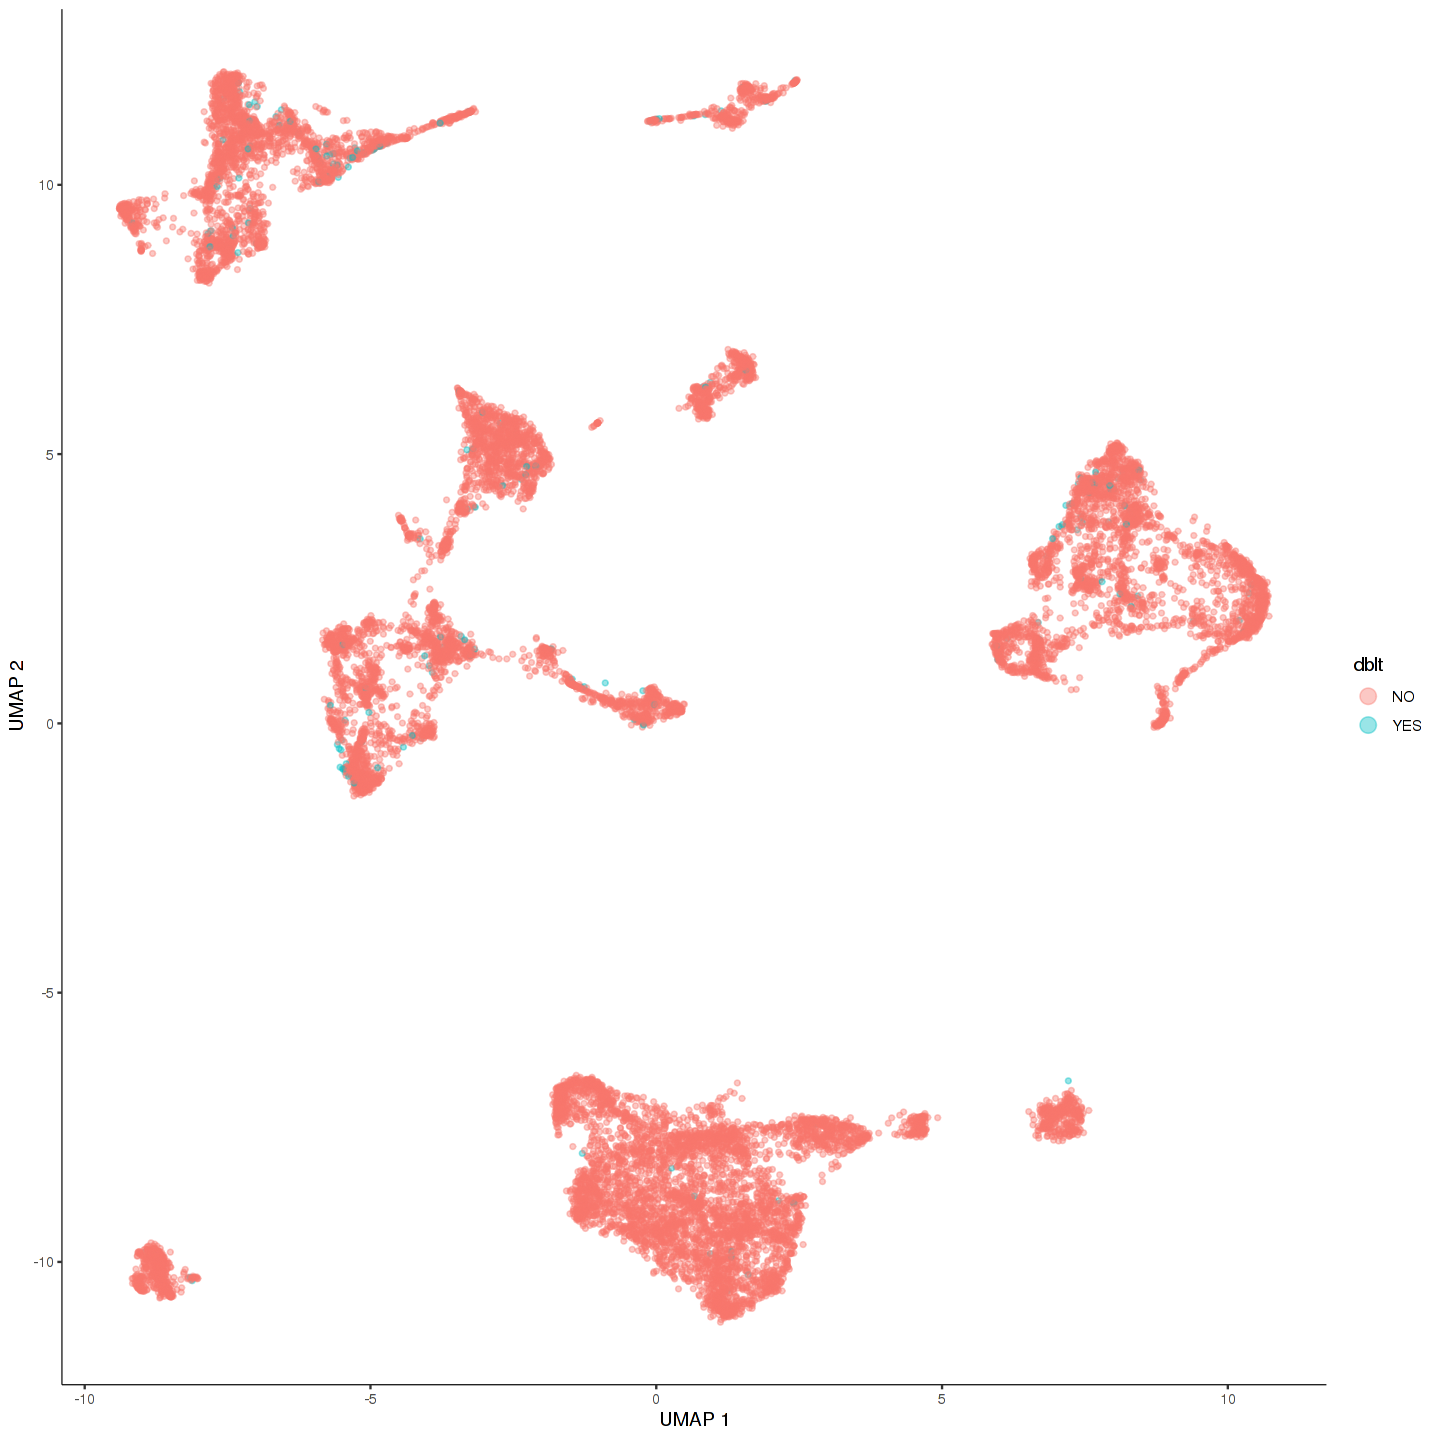

In [15]:
## Add Scrublet UMAP embedding to Monocle Cell Set
down_stdycds_rmQC_3 <- down_stdycds_rmQC
# rownames(Scrub_umap) <- Scrub_bar3
Scrub_xy <- cbind(Scrub_umap[colnames(down_stdycds_rmQC), 1], Scrub_umap[colnames(down_stdycds_rmQC), 2])
## Remapping (should be the right thing to do, otherwise could use Scrub_umap instead of Scrub_xy
down_stdycds_rmQC_3@reducedDims@listData$UMAP <- cbind(down_stdycds_rmQC@reducedDims@listData$UMAP,
                                                      Scrub_xy)

colData(down_stdycds_rmQC_3)$dblt <- Scrub_umap[colnames(down_stdycds_rmQC), 3]
dblt_b <- colData(down_stdycds_rmQC_3)$dblt == 'YES'
colData(down_stdycds_rmQC_3)$score <- Scrub_umap[colnames(down_stdycds_rmQC), 4]

## Plot the Monocle cell set using Scrublet embedding, but using the Monocle clustering as colorization
## This to some degree confirms, more or less, that Scrublet and Monocle UMAP Embedding is Similar
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(2,1))
plot_cells(x = 3, y = 4, down_stdycds_rmQC_3, color_cells_by = "dblt", group_cells_by = "partition",
                   label_cell_groups = FALSE, group_label_size = 5,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 1, alpha = .4)
plot_cells(x = 1, y = 2, down_stdycds_rmQC_3, color_cells_by = "dblt", group_cells_by = "partition",
                   label_cell_groups = FALSE, group_label_size = 5,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 1, alpha = .4)

In [97]:
## Repeated from above, this time to a file
f1 <- paste(ps$outdir, 'GeneExcl/Rev1/Scrublet_Plot.Scrublet_umap.Monocle_umap.pdf', sep = '')
pdf(f1, width = 12, height = 12)
par(mfrow=c(1,2))
plot_cells(x = 3, y = 4, down_stdycds_rmQC_3, color_cells_by = "score", group_cells_by = "partition",
                   label_cell_groups = FALSE, group_label_size = 5,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 2, alpha = .4)
plot_cells(x = 1, y = 2, down_stdycds_rmQC_3, color_cells_by = "score", group_cells_by = "partition",
                   label_cell_groups = FALSE, group_label_size = 5,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 2, alpha = .4)
dev.off()

png 
  2

In [77]:
help(plot_cells)

## DoubletDecon Summary Reporting

In [16]:
## Read the DoubletDecon Results (Fix the barcode from dotted format to dashed format)
DDcon_nonDB_bar <- rownames(read.table( paste(ps$outdir, 'DDcon/Rev2/Final_nondoublets_groups_DDcon.Run2.txt', sep = ''),
            header = TRUE, stringsAsFactors = FALSE))
substr(DDcon_nonDB_bar, 17, 17) <- '-'
DDcon_DB_bar <- rownames(read.table( paste(ps$outdir, 'DDcon/Rev2/Final_doublets_groups_DDcon.Run2.txt', sep = ''),
            header = TRUE, stringsAsFactors = FALSE))
substr(DDcon_DB_bar, 17, 17) <- '-'

In [17]:
## Create colData marking the DDcon doublet (TRUE or FALSE)
## in Remixed cells set with QC failed cells removed
DDcon_nonDB_s <- which(down_bar_rmQC %in% DDcon_nonDB_bar)
DDcon_DB_s <- which(down_bar_rmQC %in% DDcon_DB_bar)
colData(down_stdycds_rmQC)$DDcon_DB[DDcon_nonDB_s] <- FALSE
colData(down_stdycds_rmQC)$DDcon_DB[DDcon_DB_s] <- TRUE

In [18]:
## Read the DoubletDecon UMAP Embedding and Cluster IDs (Seurat)
DDcon_embed <- read.table(file = paste(ps$outdir, '/DDcon/Rev2/UMAP.Embedding.txt', sep = ''),
            header = TRUE, stringsAsFactors = FALSE)
DDcon_clust <- read.table(file = paste(ps$outdir, '/DDcon/Rev2/Clusters.txt', sep = ''),
            header = TRUE, stringsAsFactors = FALSE)

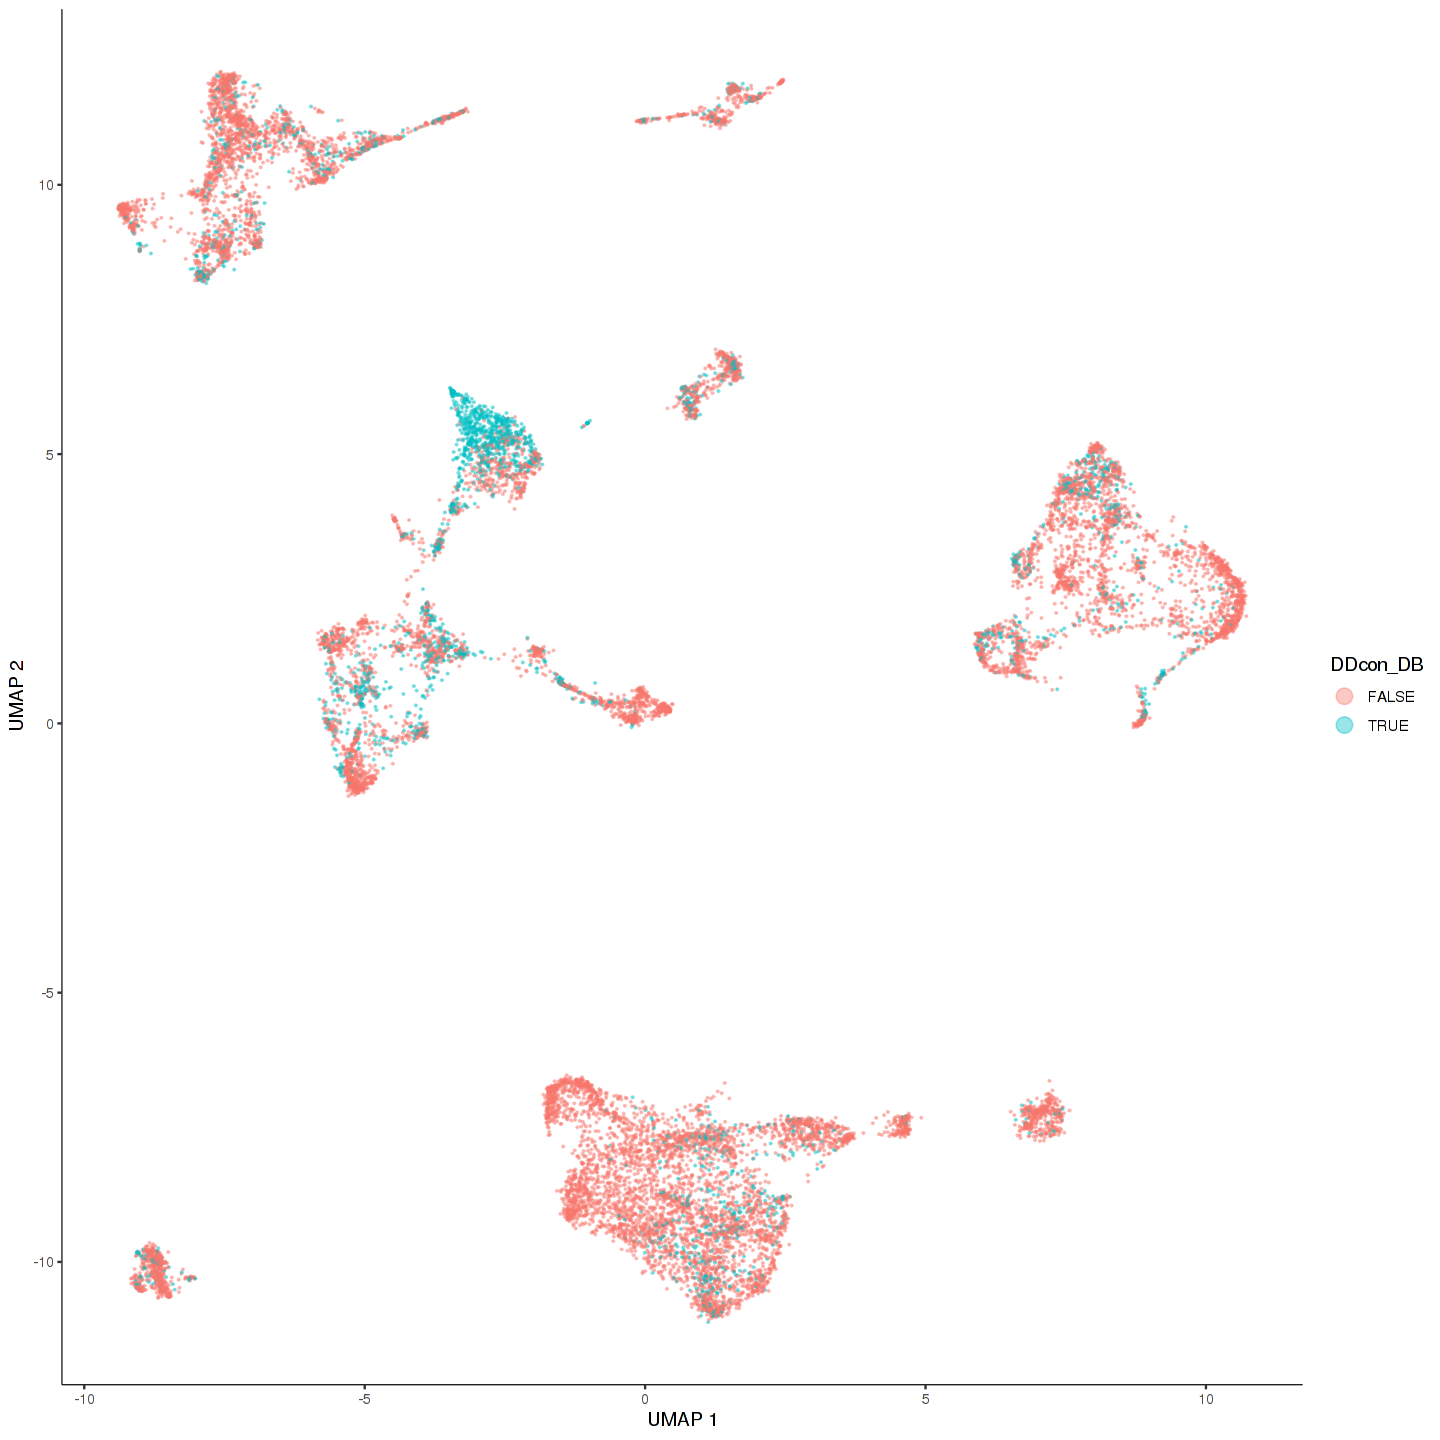

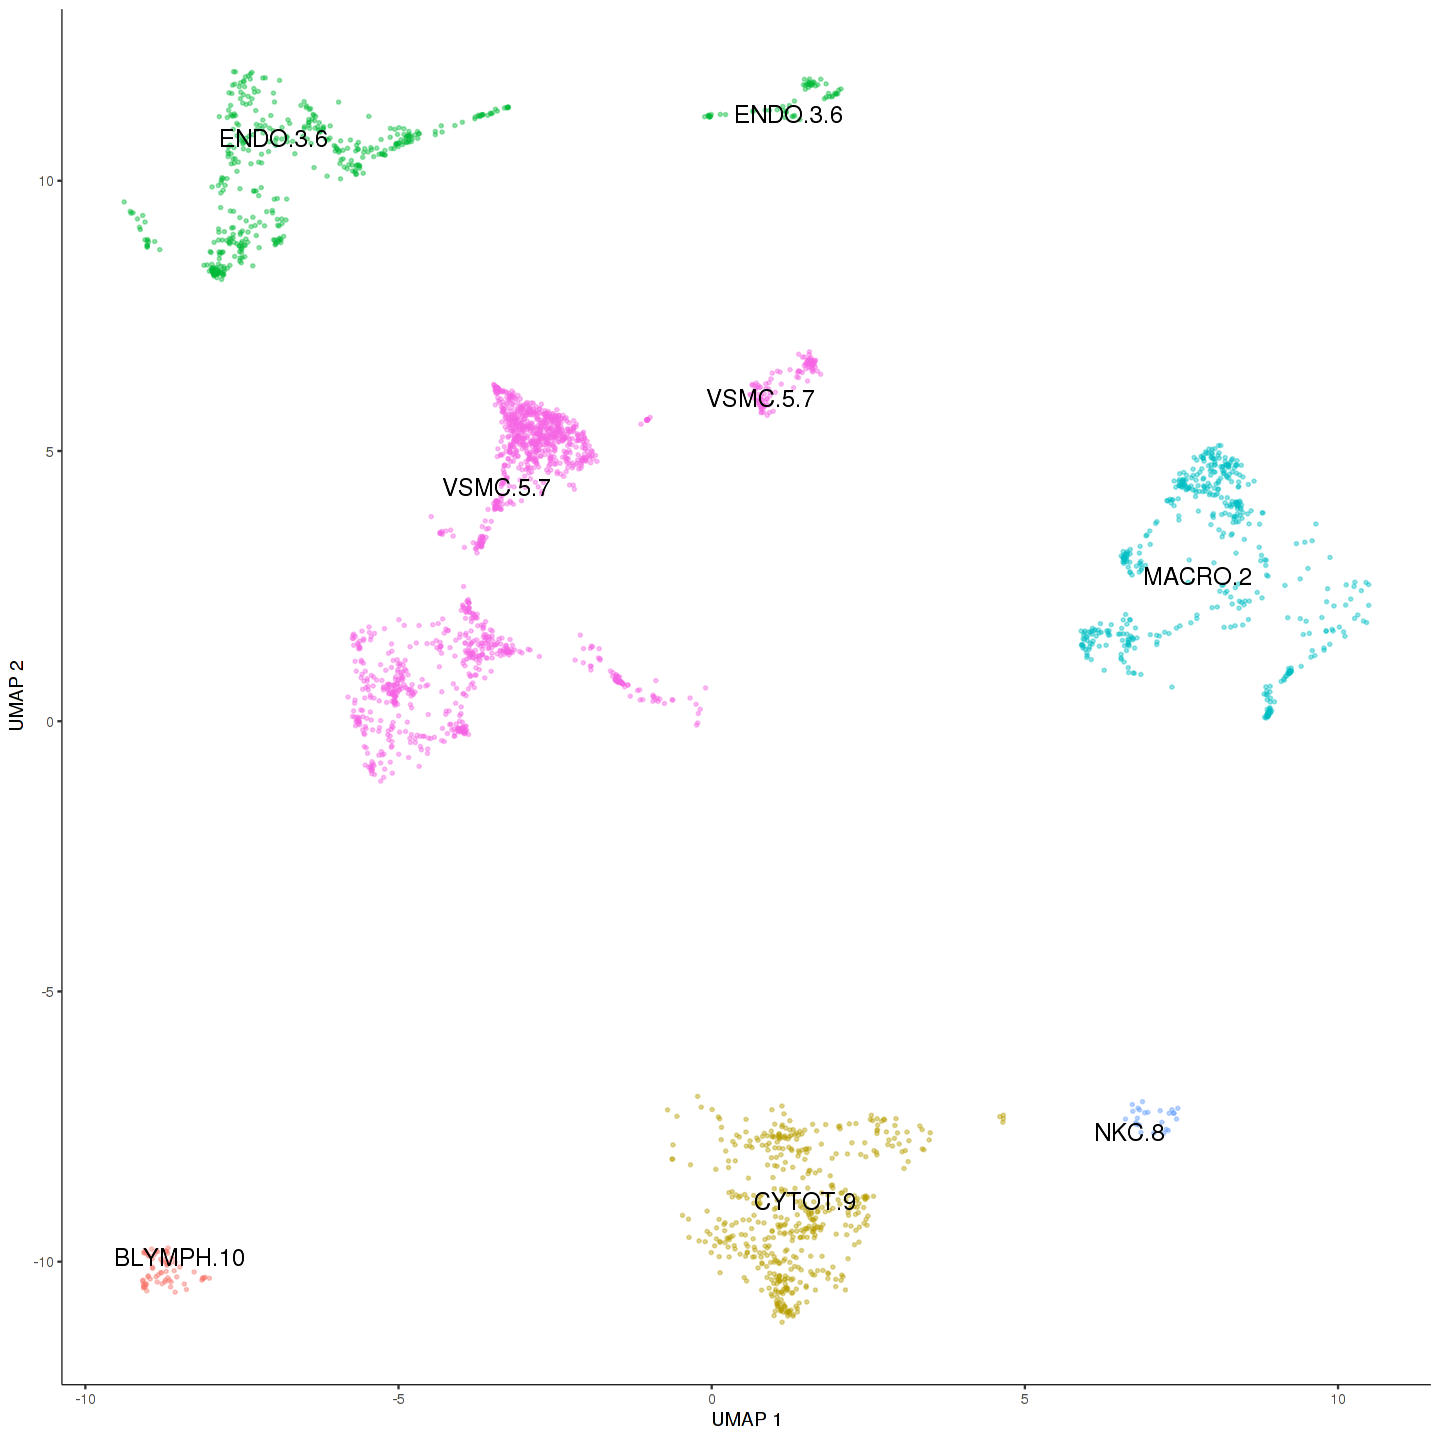

In [460]:
## Plot DDcon Doublets and all cells colorized by Doublet
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(2,1))
plot_cells(down_stdycds_rmQC, color_cells_by = "DDcon_DB", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .1, alpha = .4)
plot_cells(down_stdycds_rmQC[, DDcon_DB_s], color_cells_by = "remix", group_cells_by = "partition",
                   label_cell_groups = TRUE, group_label_size = 5,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .5, alpha = .4)

## Compare Monocle and Seurat Clustering

In [19]:
padded_nums <- c('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12')
## Add the DoubletDecon cluster ids to the cell set object (cluster ids are from Seurat)
# colors2add <- rainbow(13)[DDcon_clust[colnames(down_stdycds_rmQC),1] + 1]
colors2add <- padded_nums[DDcon_clust[colnames(down_stdycds_rmQC),1] + 1]
colData(down_stdycds_rmQC)$DDclust <- colors2add 

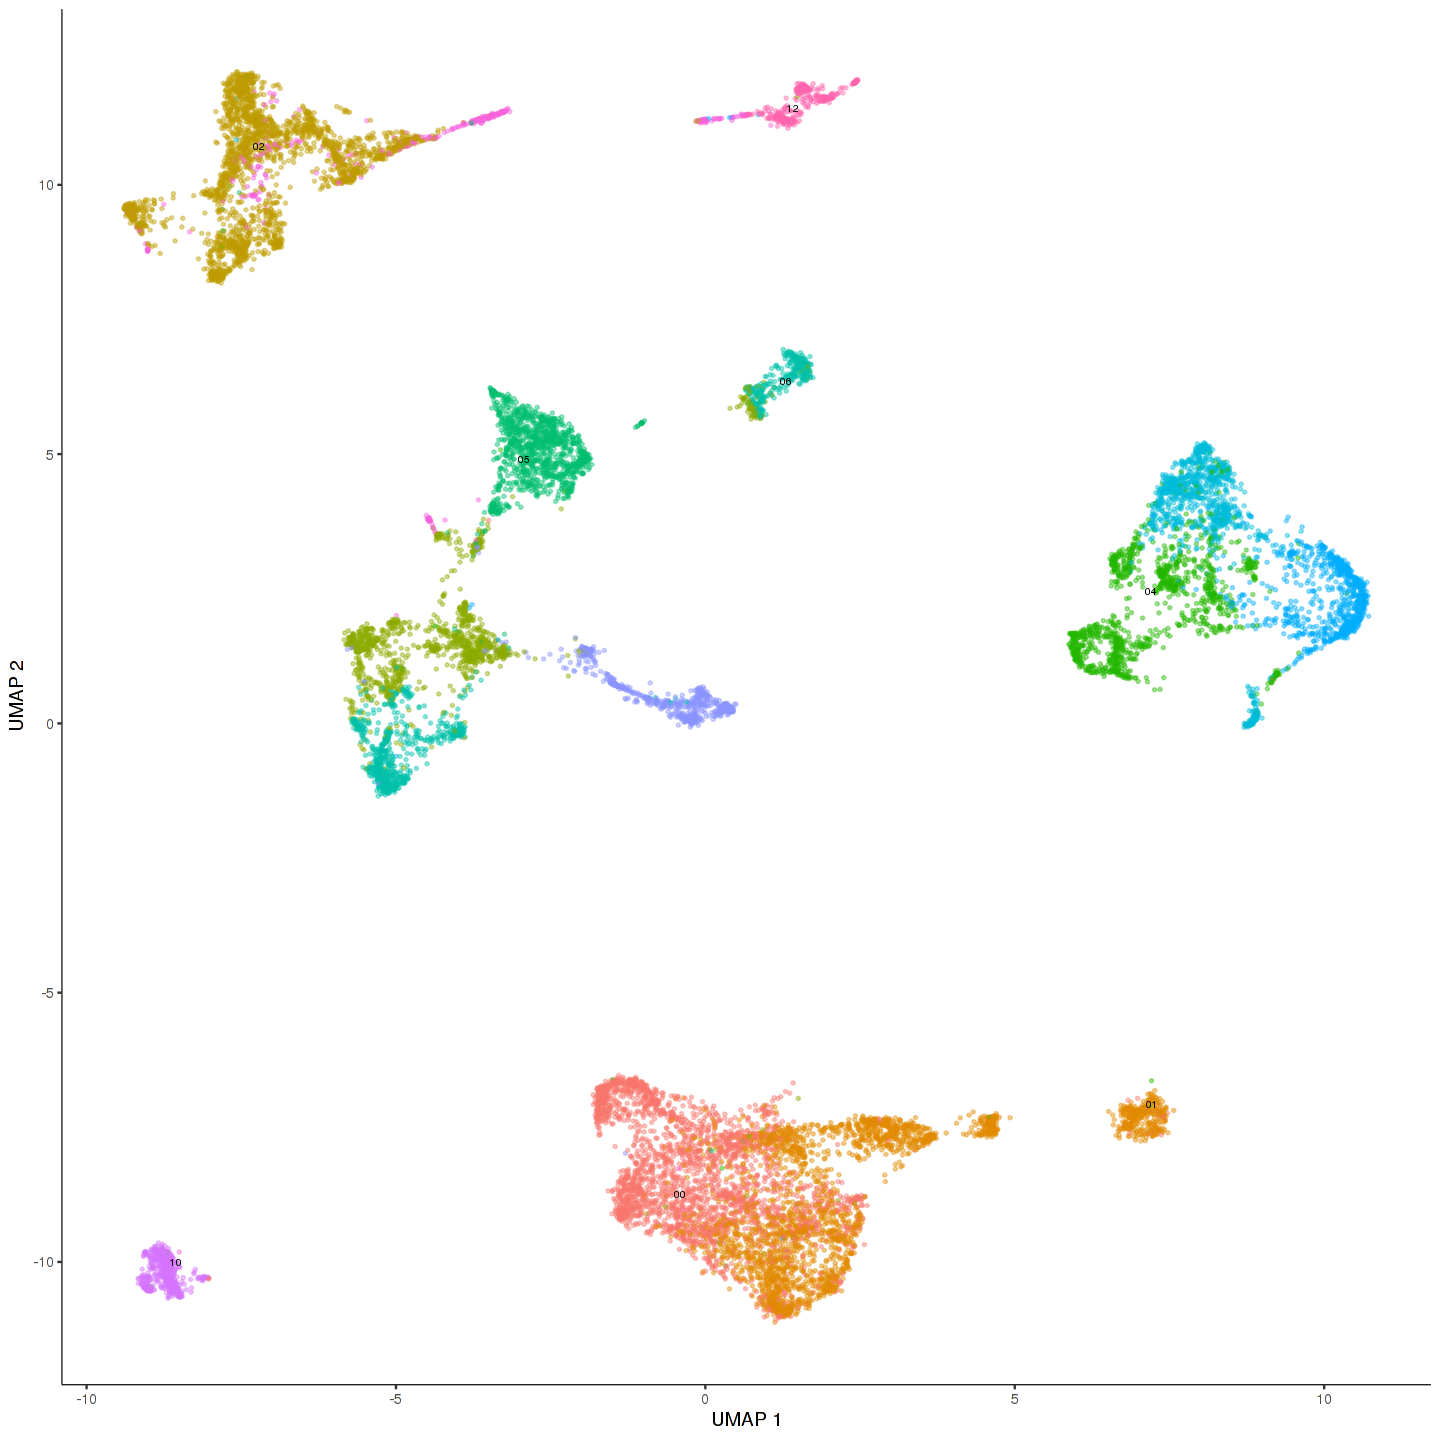

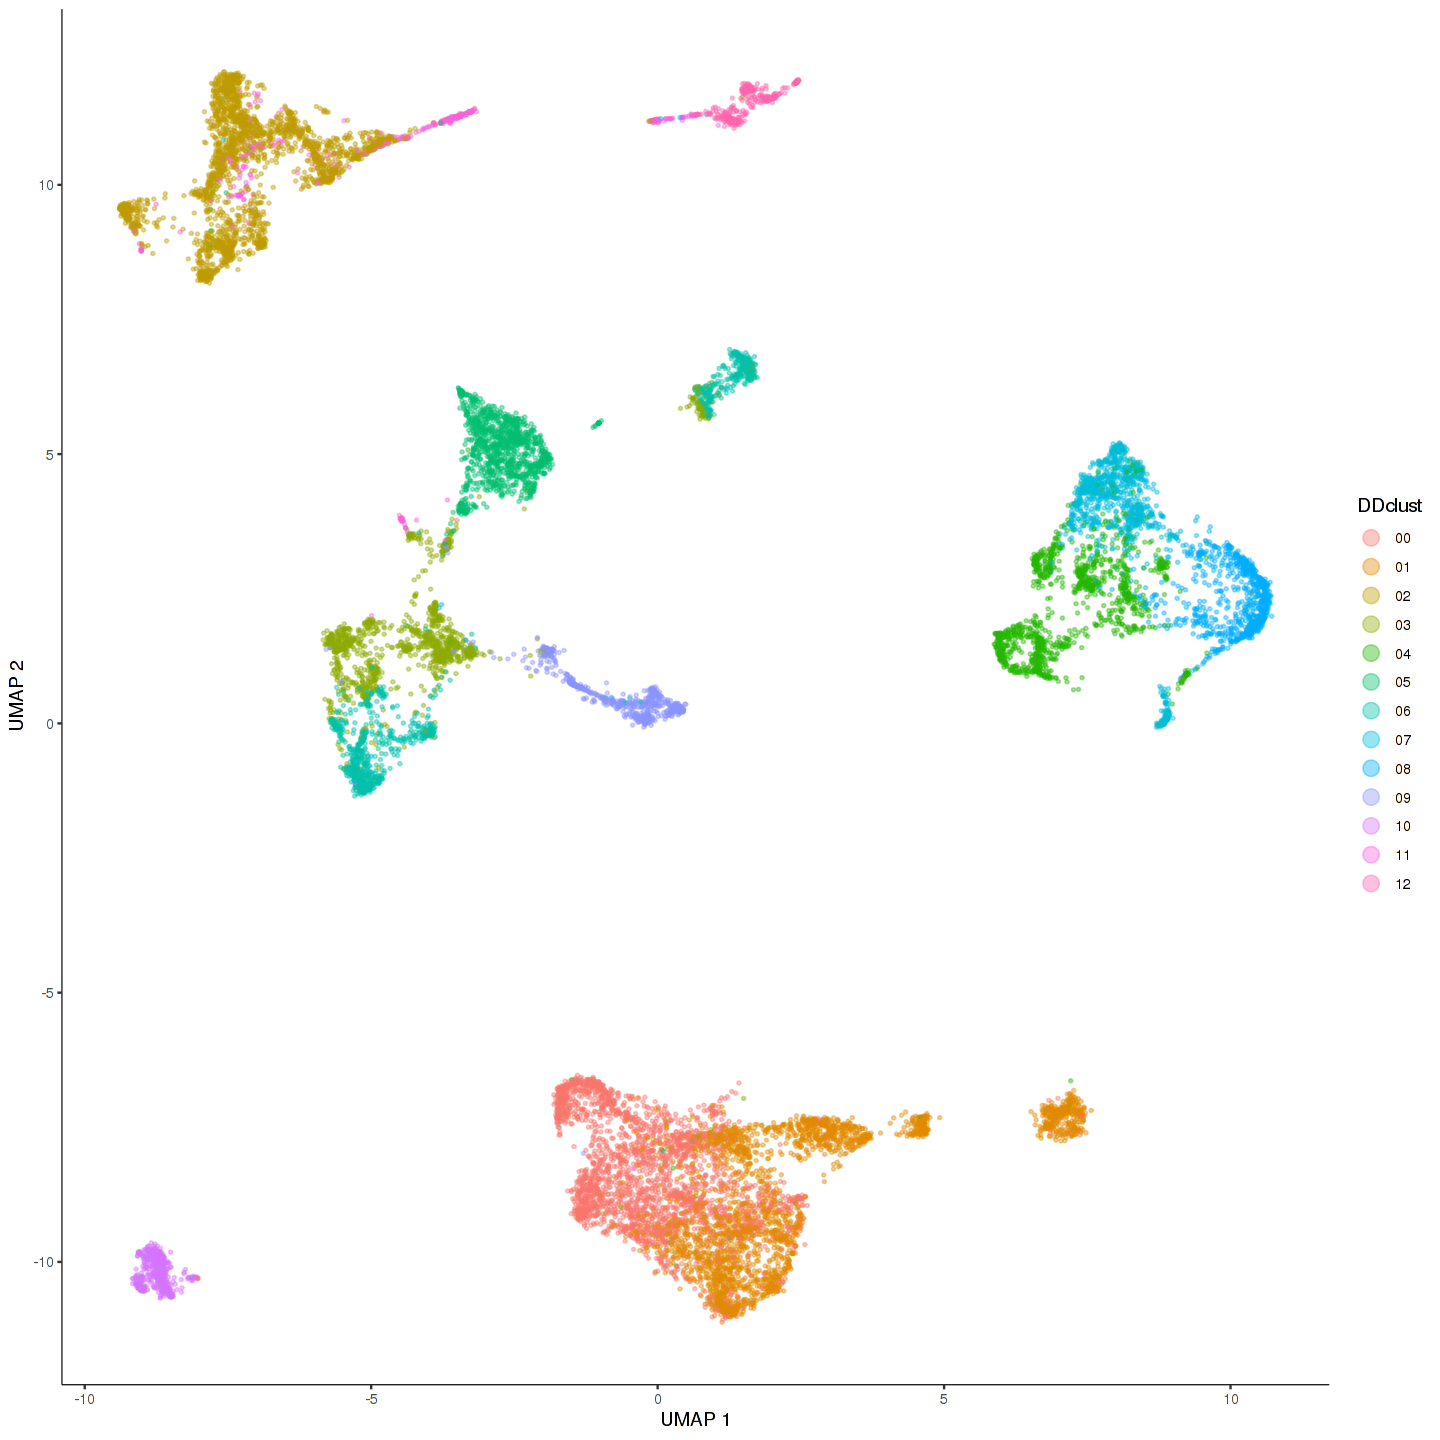

In [411]:
## Plot the Monocle cell set using its UMAP embedding, but using the Seurat clustering as colorization
## This to some degree confirms, more or less, that Seurat and Monocle UMAP Embedding is Similar
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(2,1))
plot_cells(down_stdycds_rmQC, color_cells_by = "DDclust", group_cells_by = "partition",
                   label_cell_groups = TRUE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .5, alpha = .4)
plot_cells(down_stdycds_rmQC, color_cells_by = "DDclust", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .5, alpha = .4)

In [20]:
## Add Seurat Embedding to Monocle Cell Set
down_stdycds_rmQC_1 <- down_stdycds_rmQC
DDCon_xy <- cbind(DDcon_embed[colnames(down_stdycds_rmQC), 1], DDcon_embed[colnames(down_stdycds_rmQC), 2])
down_stdycds_rmQC_1@reducedDims@listData$UMAP <- cbind(down_stdycds_rmQC@reducedDims@listData$UMAP,
                                                      DDCon_xy)

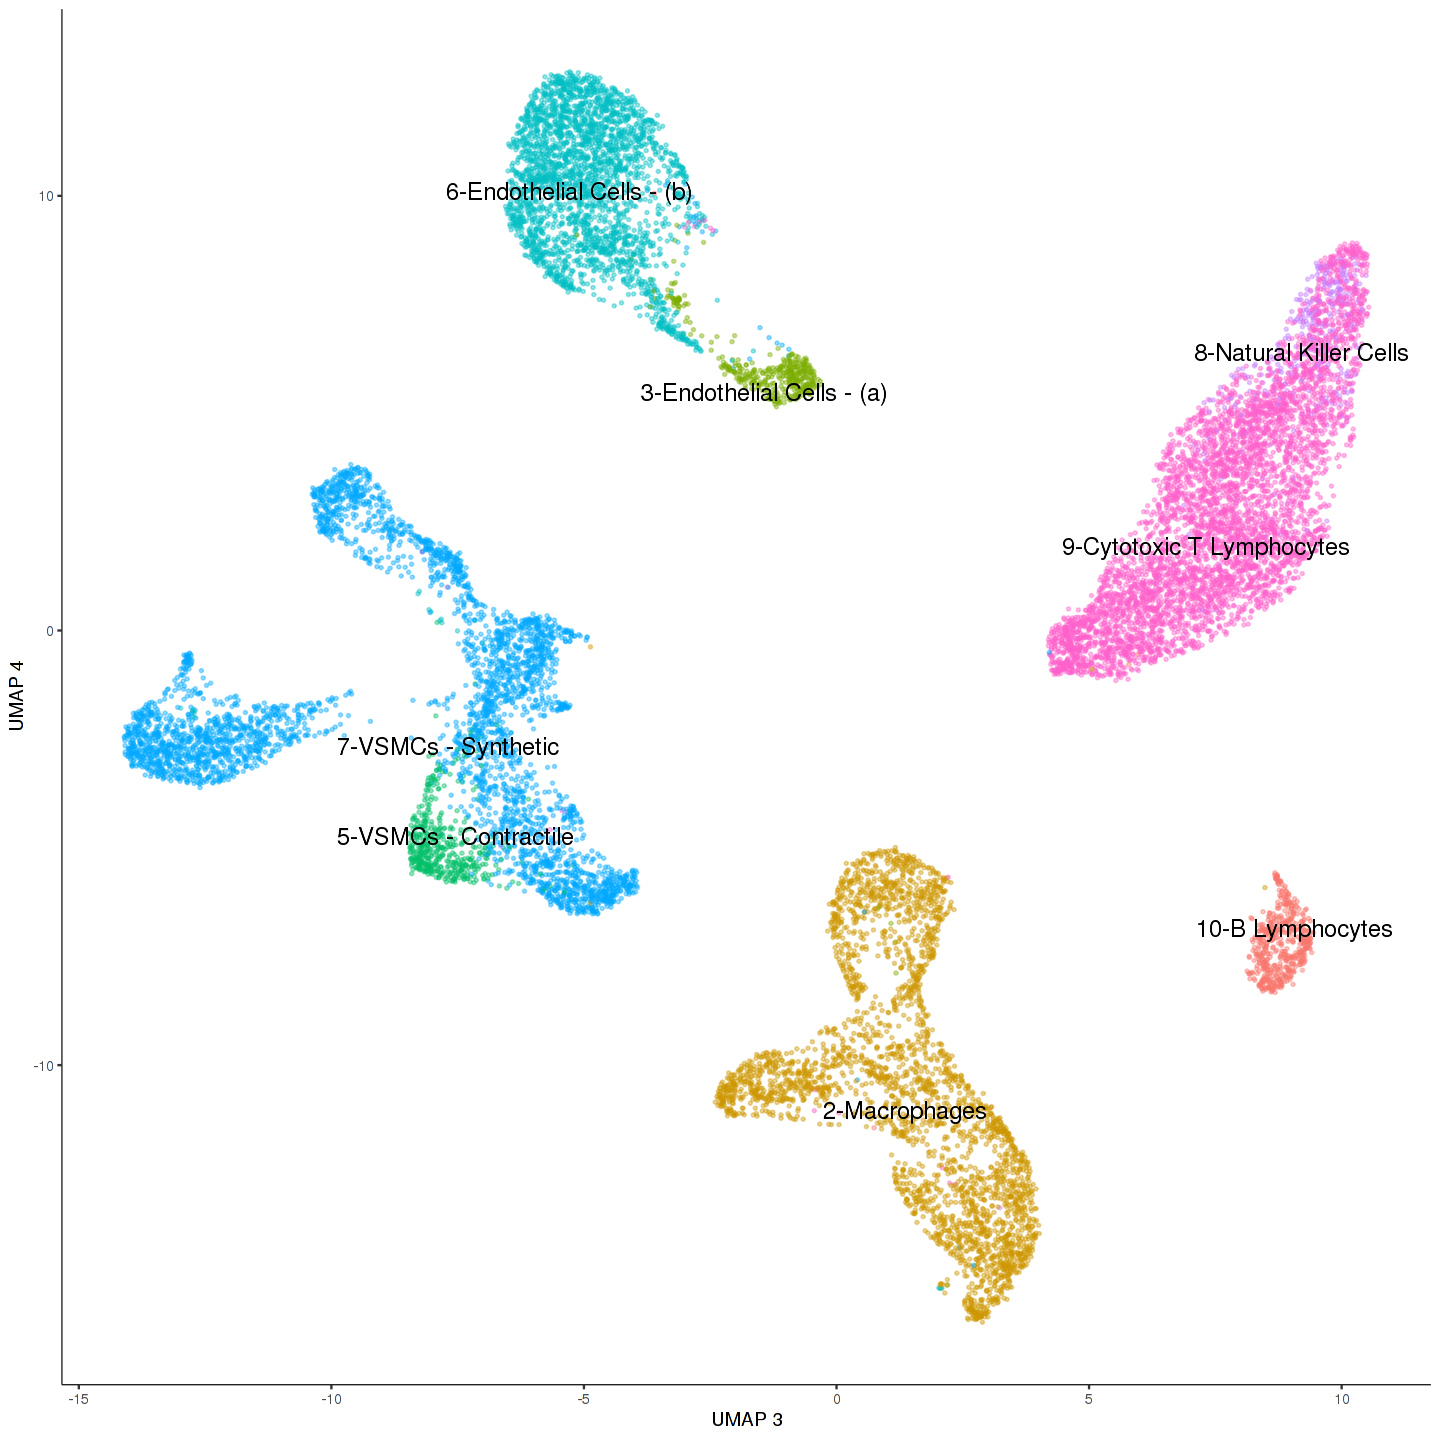

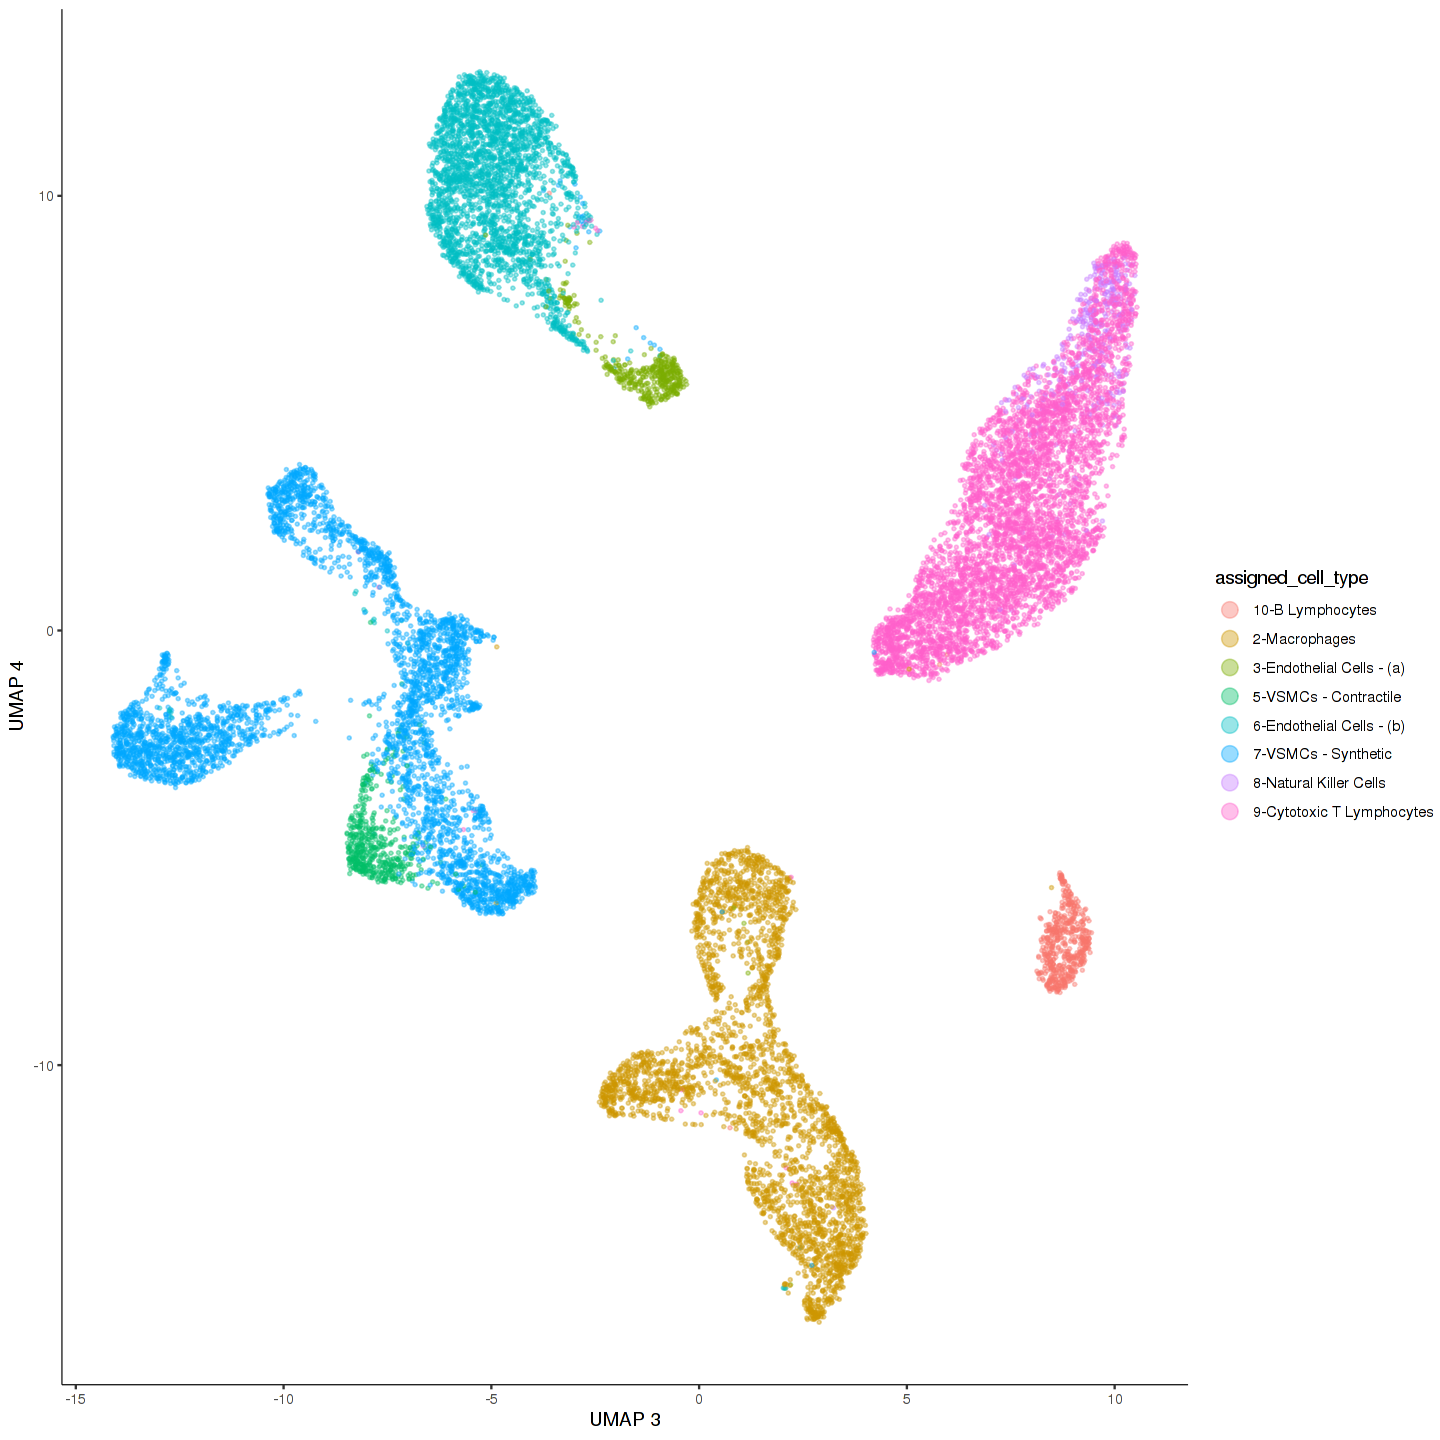

In [446]:
## Plot the Monocle cell set using Seurat embedding, but using the Monocle clustering as colorization
## This to some degree confirms, more or less, that Seurat and Monocle UMAP Embedding is Similar
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(2,1))
plot_cells(x = 3, y = 4, down_stdycds_rmQC_1, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = TRUE, group_label_size = 5,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .5, alpha = .4)
plot_cells(x = 3, y = 4, down_stdycds_rmQC_1, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .5, alpha = .4)

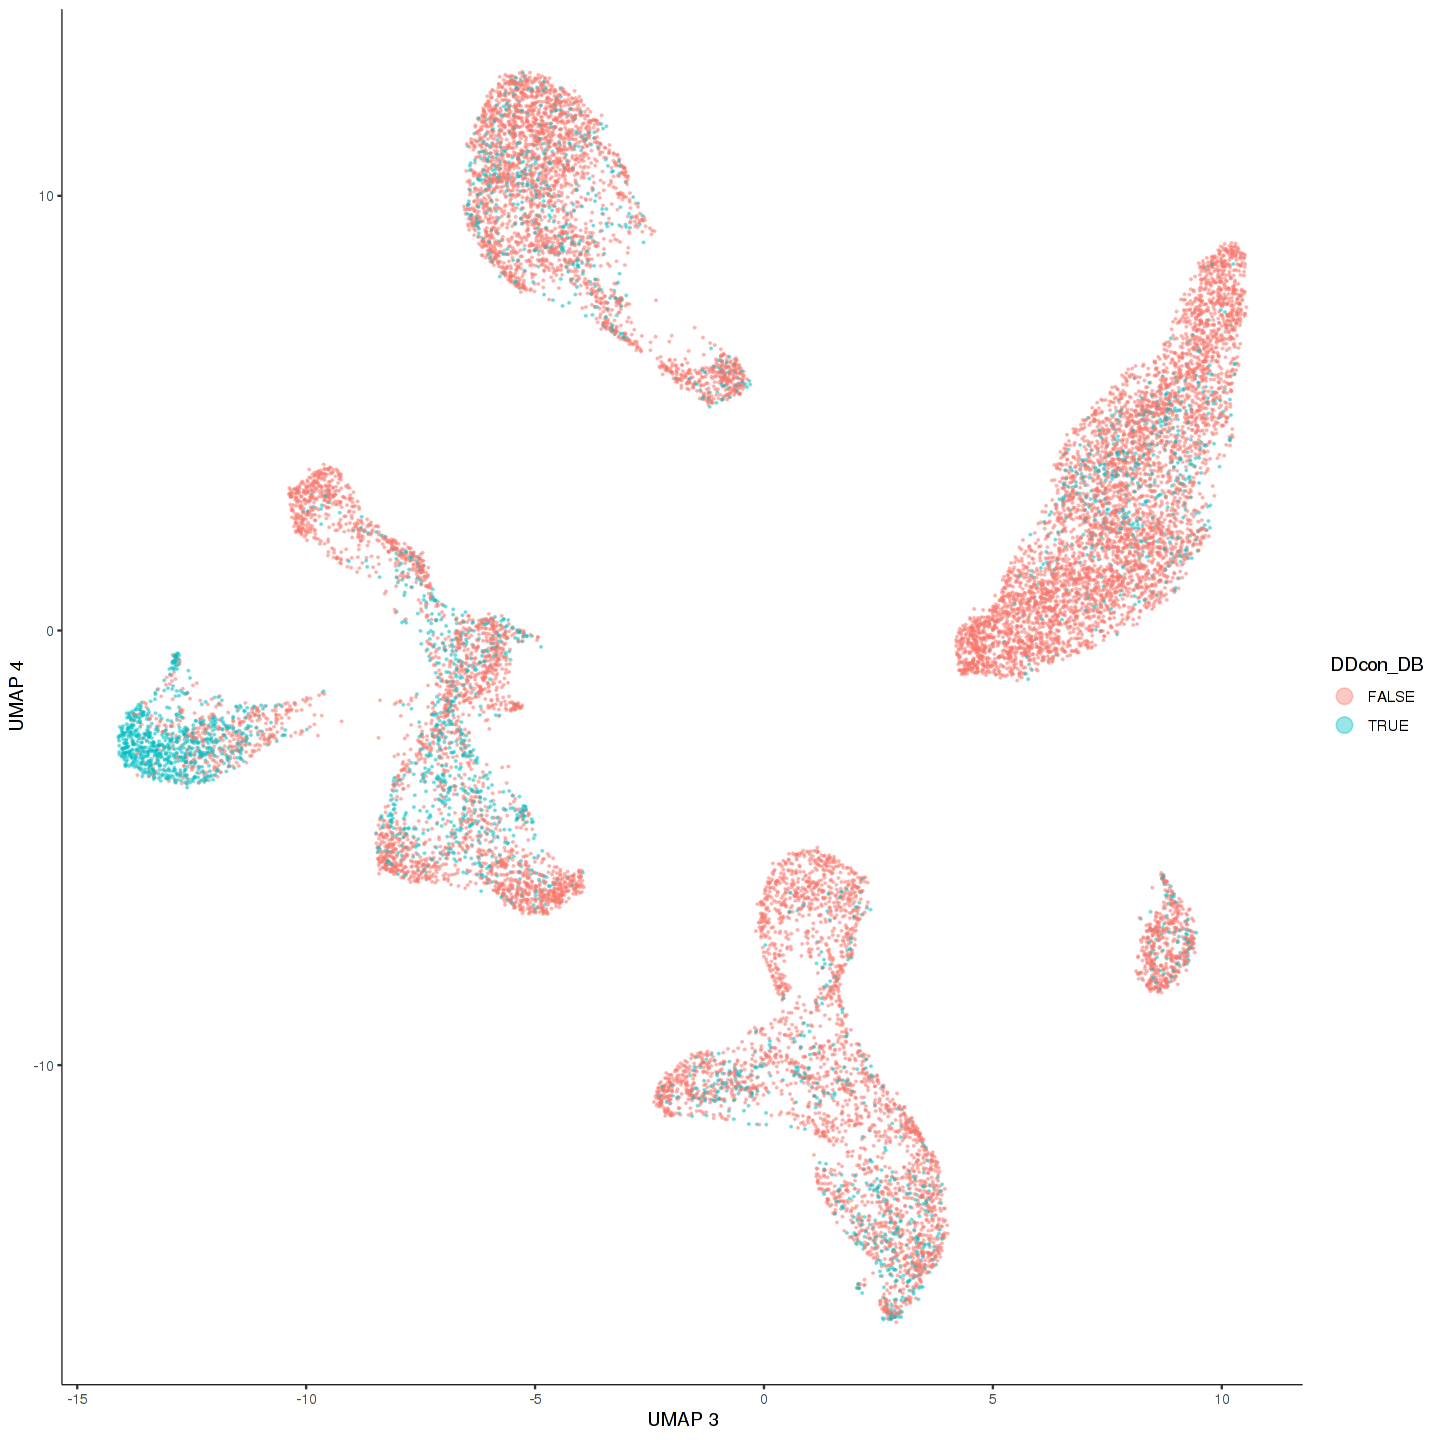

In [444]:
## Plot Cells Using the Seurat Embedding, but Colorized by DoubletDecon Doublets 
plot_cells(x=3, y=4, down_stdycds_rmQC_1, color_cells_by = "DDcon_DB", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .1, alpha = .4)

## Overlap Analysis

In [21]:
## Check the overlaps between Gene Exclusion Doublets and DoubletDecon Doublets
length(GE_BL_rmQC_bar[,1])
length(DDcon_DB_bar)
length(GE_DB_bar[,1])
sum(GE_DB_bar[,1] %in% DDcon_DB_bar)

[1] 16287

[1] 3023

[1] 3217

[1] 603

In [22]:
## Check Scrublet overlaps with DoubletDecon and Gene Exclusion
length(Scrub_DB_bar)
sum(Scrub_DB_bar %in% DDcon_DB_bar)
sum(Scrub_DB_bar %in% GE_DB_bar[,1])

[1] 207

[1] 91

[1] 195

In [23]:
## Check overlap of Scrublet, DoubletDecon, and Gene Exclusion
Scrub2DDcon <- Scrub_DB_bar[Scrub_DB_bar %in% DDcon_DB_bar]
Scrub2GE <- Scrub_DB_bar[Scrub_DB_bar %in% GE_DB_bar[,1]]
sum(Scrub2DDcon %in% Scrub2GE)

[1] 87

In [47]:
sum(!(GE_BL_rmQC_bar[,1] %in% Scrub_DB_bar))
sum((GE_BL_rmQC_bar[,1] %in% Scrub_DB_bar))

[1] 16080

[1] 207

## UMI Analysis

In [24]:
## Changes in Doublet UMI Relative to Background Cell Set
## Get the expression data and compute the total UMI counts per cell
dsqc_exp <- exprs(down_stdycds_rmQC)
dsqc_csums <- colSums(dsqc_exp)

In [25]:
## Verify that the doublet cell barcodes in the exression data match cell sets
sum(names(dsqc_csums) %in% c(GE_BL_rmDB_rmQC_bar[,1], GE_DB_bar[,1]))
sum(names(dsqc_csums) %in% c(DDcon_nonDB_bar, DDcon_DB_bar))

[1] 16287

[1] 16287

In [26]:
## Get the barcodes for the diseased and healthy cells
dis_bar <- colnames(down_stdycds_rmQC)[colData(down_stdycds_rmQC)$condition == 'diseased']
length(dis_bar)
hea_bar <- colnames(down_stdycds_rmQC)[colData(down_stdycds_rmQC)$condition == 'healthy']
length(hea_bar)

[1] 8044

[1] 8243

In [27]:
## Compare the mean cell UMI counts in the GE Method
mean(dsqc_csums[GE_BL_rmDB_rmQC_bar[,1]])
mean(dsqc_csums[GE_DB_bar[,1]])
t.test(dsqc_csums[GE_BL_rmDB_rmQC_bar[,1]], dsqc_csums[GE_DB_bar[,1]],
       alternative = "less")

[1] 5100.871

[1] 6029.955


	Welch Two Sample t-test

data:  dsqc_csums[GE_BL_rmDB_rmQC_bar[, 1]] and dsqc_csums[GE_DB_bar[, 1]]
t = -11.77, df = 4182.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -799.2172
sample estimates:
mean of x mean of y 
 5100.871  6029.955 


In [28]:
## Compare the mean cell UMI counts in the Scrublet Method
mean(dsqc_csums[Scrub_bar[Scrub_DB_i == 0]])
mean(dsqc_csums[Scrub_bar[Scrub_DB_i == 1]])
t.test(dsqc_csums[Scrub_bar[Scrub_DB_i == 0]], dsqc_csums[Scrub_bar[Scrub_DB_i == 1]],
       alternative = "less")

[1] 5282.247

[1] 5450.382


	Welch Two Sample t-test

data:  dsqc_csums[Scrub_bar[Scrub_DB_i == 0]] and dsqc_csums[Scrub_bar[Scrub_DB_i == 1]]
t = -0.71443, df = 211.57, p-value = 0.2379
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
    -Inf 220.671
sample estimates:
mean of x mean of y 
 5282.247  5450.382 


In [29]:
## Compare the mean cell UMI counts in the DDcon Method
mean(dsqc_csums[DDcon_nonDB_bar])
mean(dsqc_csums[DDcon_DB_bar])
t.test(dsqc_csums[DDcon_nonDB_bar], dsqc_csums[DDcon_DB_bar],
       alternative = "less")

[1] 5223.279

[1] 5552.493


	Welch Two Sample t-test

data:  dsqc_csums[DDcon_nonDB_bar] and dsqc_csums[DDcon_DB_bar]
t = -4.5603, df = 4303.5, p-value = 2.625e-06
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -210.4435
sample estimates:
mean of x mean of y 
 5223.279  5552.493 


In [30]:
## GE Method with out UMI uptick criteria (Still requires 2 genes)
GE_gene_only <- (colData(down_stdycds_rmQC)$p1.0 >= 2)
sum(!GE_gene_only)
mean(dsqc_csums[!GE_gene_only])
sum(GE_gene_only)
mean(dsqc_csums[GE_gene_only])
t.test(dsqc_csums[!GE_gene_only], dsqc_csums[GE_gene_only],
       alternative = "less")

[1] 12211

[1] 5237.516

[1] 4076

[1] 5424.789


	Welch Two Sample t-test

data:  dsqc_csums[!GE_gene_only] and dsqc_csums[GE_gene_only]
t = -2.7267, df = 5985.9, p-value = 0.003208
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -74.28352
sample estimates:
mean of x mean of y 
 5237.516  5424.789 


In [31]:
## GE Method with out UMI uptick criteria (Requires 4 genes)
GE_gene_only <- (colData(down_stdycds_rmQC)$p1.0 >= 4)
GE_gene_only4 <- GE_gene_only
sum(!GE_gene_only)
mean(dsqc_csums[!GE_gene_only])
sum(GE_gene_only)
mean(dsqc_csums[GE_gene_only])
t.test(dsqc_csums[!GE_gene_only], dsqc_csums[GE_gene_only],
       alternative = "less")

[1] 14898

[1] 5193.928

[1] 1389

[1] 6254.582


	Welch Two Sample t-test

data:  dsqc_csums[!GE_gene_only] and dsqc_csums[GE_gene_only]
t = -8.7462, df = 1538, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf -861.063
sample estimates:
mean of x mean of y 
 5193.928  6254.582 



   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
8645 3566 1760  927  459  278  158  100   62   64   52   50   37   40   35   22 
  16   17   18   19   21   23 
  15    8    5    2    1    1 

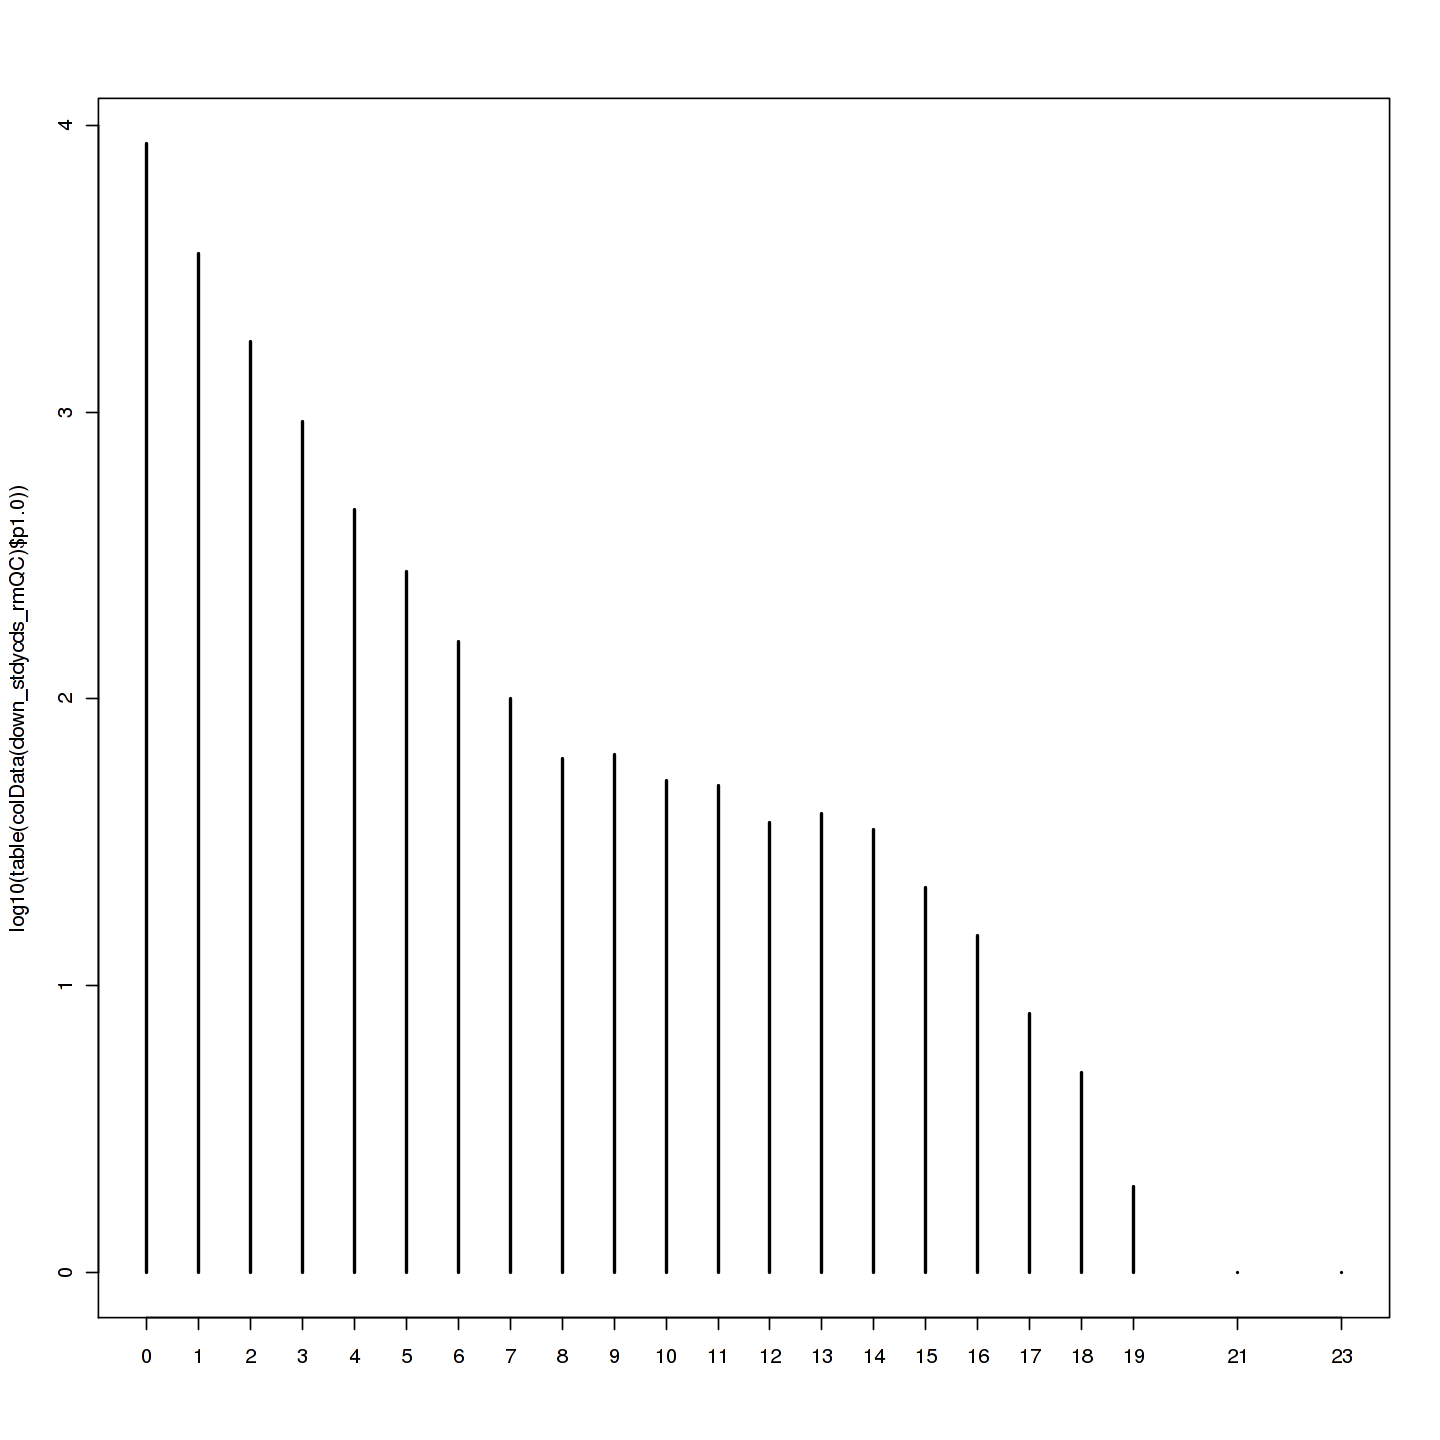

In [32]:
## Display the distribution of rare gene occurances (in cells)
table(colData(down_stdycds_rmQC)$p1.0)
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow=c(1,1))
plot(log10(table(colData(down_stdycds_rmQC)$p1.0)))

In [33]:
## Count overlaps for DDcon and GE, and Then DDCon and GE without UMI condition,
## but increase rare gene condition to 4
dim(down_stdycds_rmQC[, GE_gene_only4])[2]
length(DDcon_DB_bar)
sum(GE_DB_bar[,1] %in% DDcon_DB_bar)
sum(colnames(down_stdycds_rmQC[, GE_gene_only4]) %in% DDcon_DB_bar)

[1] 1389

[1] 3023

[1] 603

[1] 319

## Disease/Healthy Doublet Splits

In [34]:
## Cell Counts and UMI Means for Disease and Healthy
length(dis_bar)
mean(dsqc_csums[dis_bar])
length(hea_bar)
mean(dsqc_csums[hea_bar])

[1] 8044

[1] 5466.795

[1] 8243

[1] 5106.376

[1] 16287

[1] 3217

[1] 2347

[1] 870

[1] 5466.795

[1] 5148.057

[1] 5106.376

[1] 5064.412

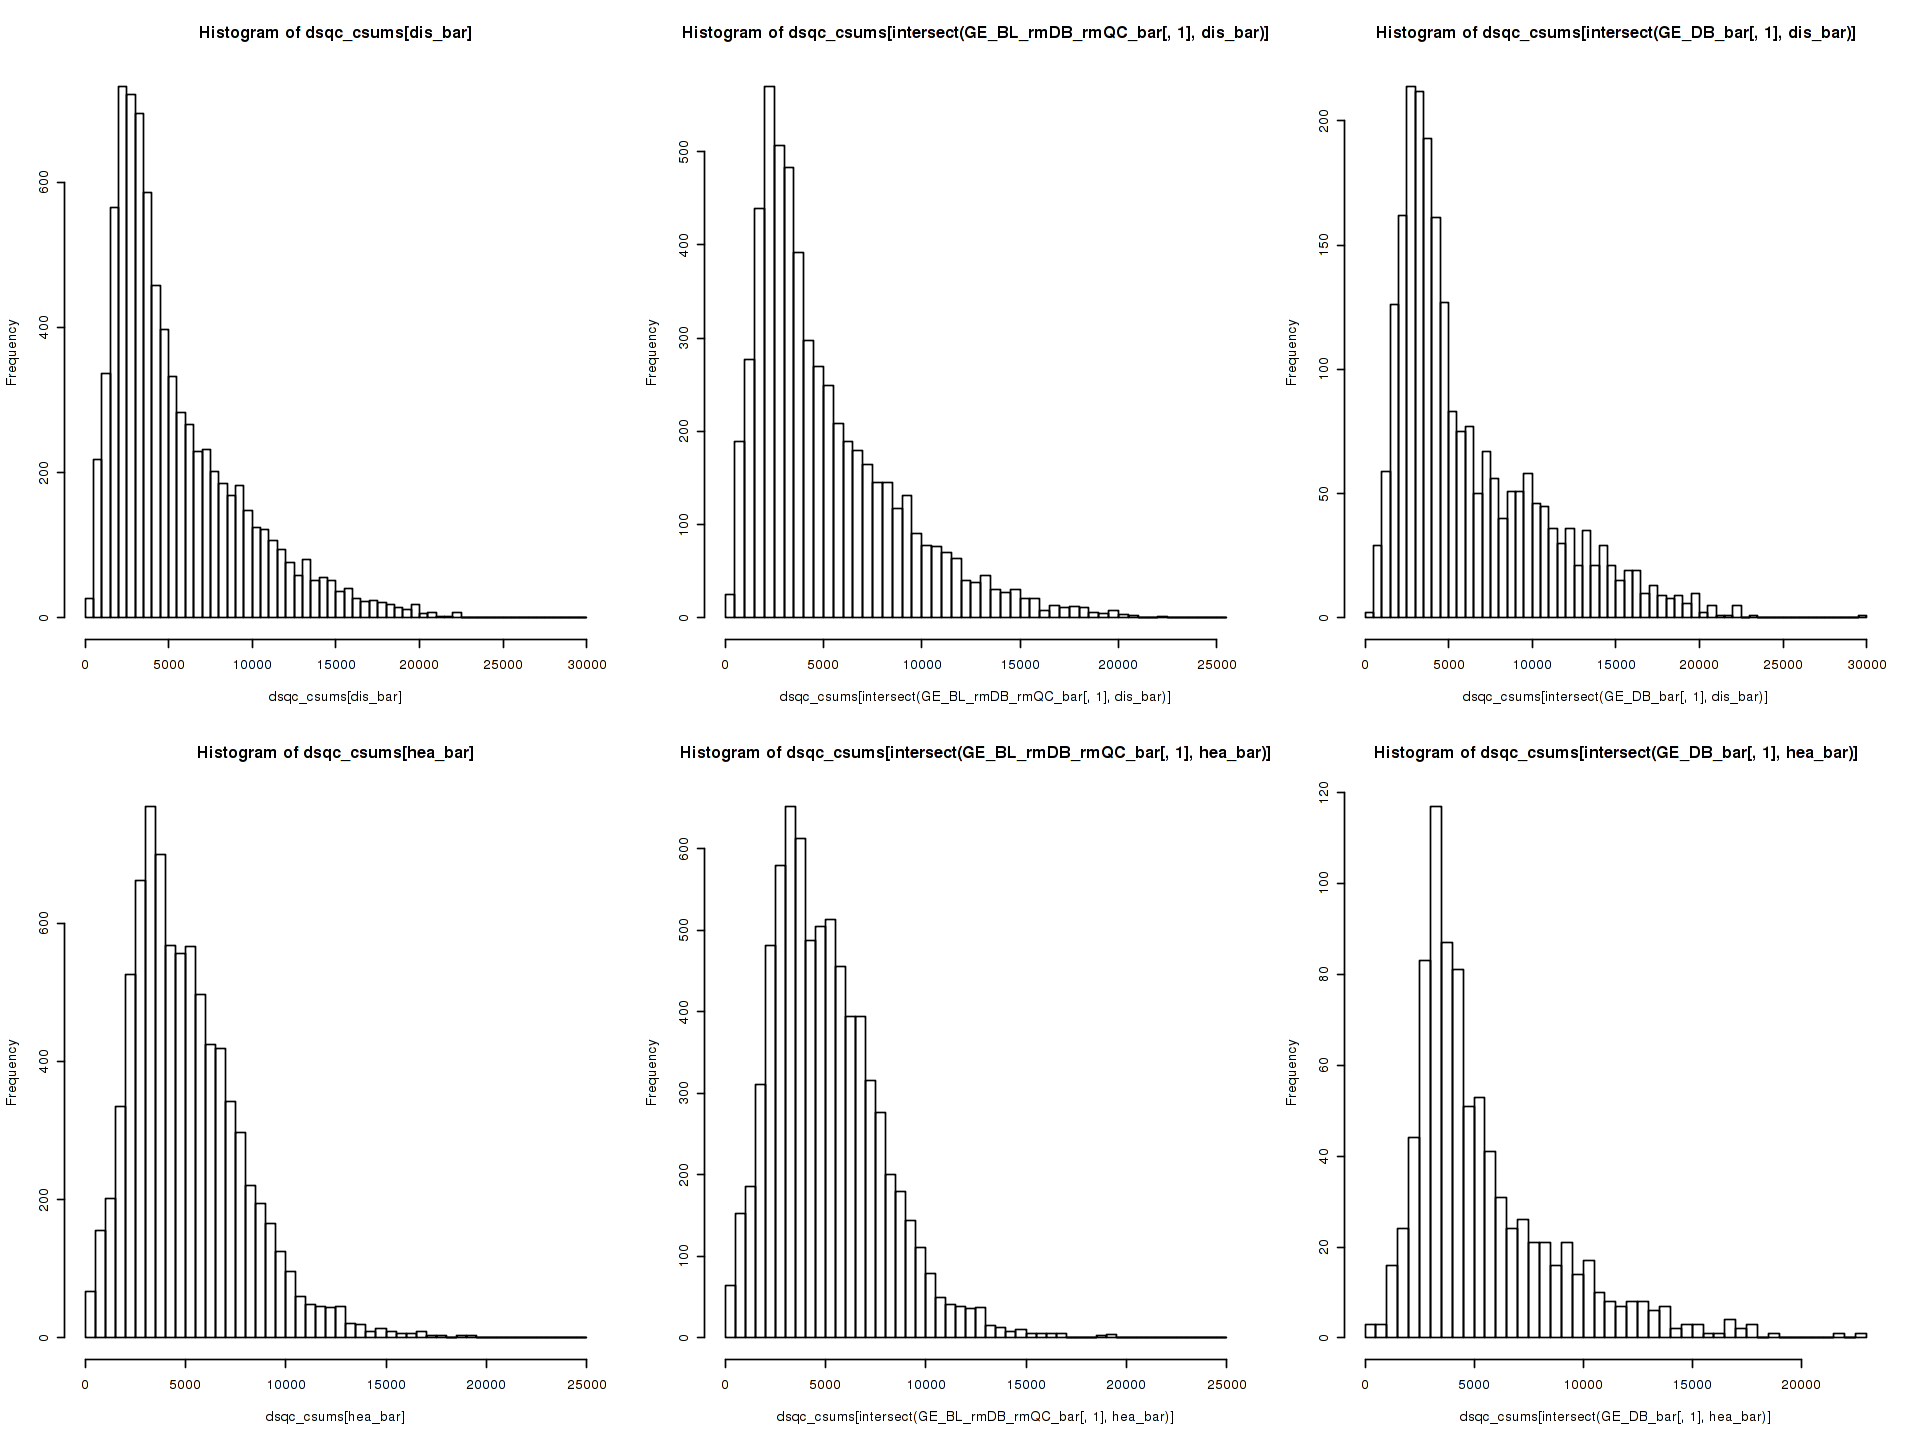

In [395]:
## GE Method (All Cells, Doublet Cells, Doublets in Disease, Doubles in Healthy)
length(GE_BL_rmQC_bar[,1])
length(GE_DB_bar[, 1])
length(intersect(GE_DB_bar[, 1], dis_bar))
length(intersect(GE_DB_bar[, 1], hea_bar))

## Breakdowns and Histograms Associated with Dis/Hea Breaks
mean(dsqc_csums[dis_bar])
mean(dsqc_csums[intersect(GE_BL_rmDB_rmQC_bar[,1], dis_bar)])
mean(dsqc_csums[hea_bar])
mean(dsqc_csums[intersect(GE_BL_rmDB_rmQC_bar[,1], hea_bar)])

library(repr)
options(repr.plot.width=16, repr.plot.height=12)
par(mfrow=c(2,3))
hist(dsqc_csums[dis_bar], breaks = 50)
hist(dsqc_csums[intersect(GE_BL_rmDB_rmQC_bar[,1], dis_bar)], breaks = 50)
hist(dsqc_csums[intersect(GE_DB_bar[, 1], dis_bar)], breaks = 50)
hist(dsqc_csums[hea_bar], breaks = 50)
hist(dsqc_csums[intersect(GE_BL_rmDB_rmQC_bar[,1], hea_bar)], breaks = 50)
hist(dsqc_csums[intersect(GE_DB_bar[, 1], hea_bar)], breaks = 50)

In [35]:
## Scrublet Method (All Cells, Doublet Cells, Doublets in Disease, Doubles in Healthy)
length(GE_BL_rmQC_bar[,1])
length(Scrub_bar[Scrub_DB_i == 1])
length(intersect(Scrub_bar[Scrub_DB_i == 1], dis_bar))
length(intersect(Scrub_bar[Scrub_DB_i == 1], hea_bar))

[1] 16287

[1] 207

[1] 81

[1] 126

In [36]:
## DDcon Method (All Cells, Doublet Cells, Doublets in Disease, Doubles in Healthy)
length(GE_BL_rmQC_bar[,1])
length(DDcon_DB_bar)
length(intersect(DDcon_DB_bar, dis_bar))
length(intersect(DDcon_DB_bar, hea_bar))

[1] 16287

[1] 3023

[1] 1304

[1] 1719

In [430]:
help(plot_cells)

In [454]:
down_stdycds_orig <- readRDS(file = paste(ps$outdir,
                    'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

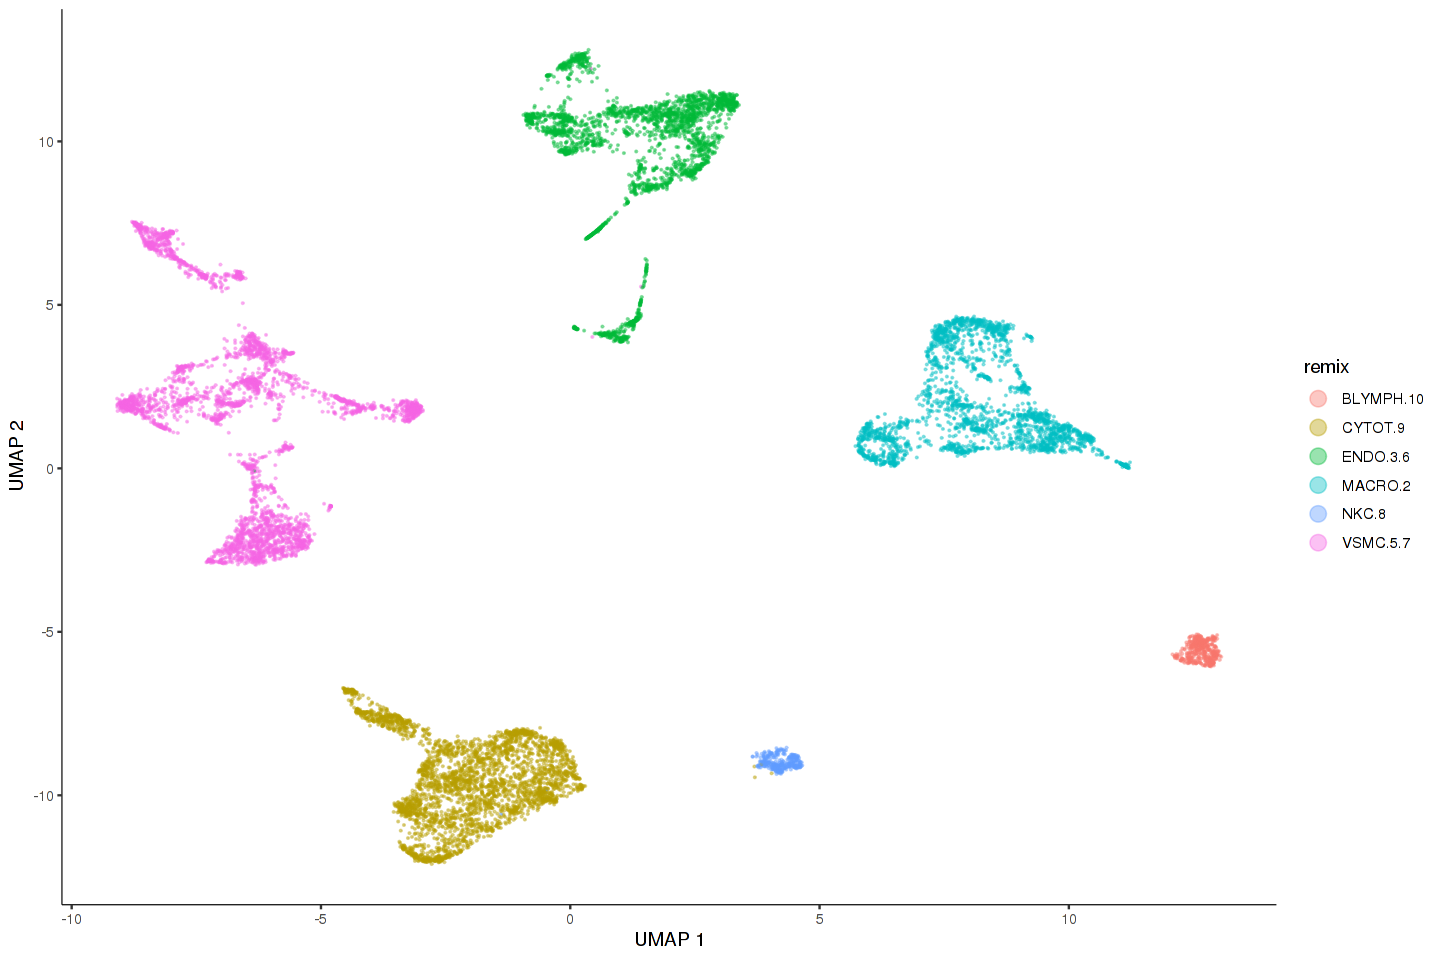

In [455]:
plot_cells(down_stdycds_orig, color_cells_by = "remix", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = .1, alpha = .4)

In [ ]:
## The following cells were added to create a table of gene expression data across all
## the cells (aggregated), specifically mean expression, variance of expression, and
## coefficient of variation. This is expected to be used by the core team
## in there implementing a targeted RNA depletion strategy to remove unneeded RNA
## prior to NGS in future single cell experiments.

In [5]:
## Read all the aggregated data into a Monocle cds object
stdycds <- load_cellranger_data(ps$indir)

In [6]:
# ex <- exprs(down_stdycds_rem)
ex <- exprs(stdycds)

In [7]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(stdycds)@rownames
names(short2geneid) <- fData(stdycds)@listData$gene_short_name

In [8]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(stdycds)@listData$gene_short_name
names(geneid2short) <- fData(stdycds)@rownames

In [9]:
## Read the GENCODE v27 Data for annotation results
v27_gen <- read.table(paste(ps$indir, 'v27_Embl_Hugo.txt', sep = ''), header = F)
v27_gen[,1] <- substr(v27_gen[,1] ,1, 15)
v27 <- read.table(paste(ps$indir, 'v27_Embl_Hugo_Type.txt', sep =''))
v27names <- substr(v27$V1, 1, 15)
v27 <- v27[!duplicated(v27names),]
rownames(v27) <- substr(v27$V1, 1, 15)

In [ ]:
## Save some space
rm(stdycds)

In [14]:
## Remove genes with zero mean expression, then create a dense expression matrix
rmeans <- rowMeans(ex)
zmeans <- rmeans == 0
ex <- as.matrix(ex[!zmeans,])
rmeans <- rowMeans(ex)

In [22]:
## Compute the variances of each gene
mgenes <- dim(ex)[1]
rvars <- vector(mode = 'double', length = mgenes)
for (i in 1:mgenes) {
    rvars[i] <- mean((ex[i, ] - rmeans[i])^2)
    cat(paste(i, '\r', sep = ''))
    flush.console()
    }

In [24]:
## Compute the coefficient of variation for each gene
covs <- (rvars^.5)/rmeans

In [25]:
## Get the geneids from the expression data
geneids <- rownames(ex)

In [41]:
## Creat the data of data
cvdat <- as.data.frame(cbind(rmeans, rvars, covs, geneids), stringsAsFactors = FALSE)

In [42]:
## Check the data table dimesions (should be about 26000 by 4)
dim(cvdat)

[1] 26200     4

In [43]:
## Convert the text columns to numeric columns
cvdat[, 1] <- as.numeric(cvdat[, 1])
cvdat[, 2] <- as.numeric(cvdat[, 2])
cvdat[, 3] <- as.numeric(cvdat[, 3])

In [44]:
## Set up to sort the table by the mean expression level
reord <- order(cvdat[, 1], decreasing = TRUE)

In [45]:
## Re-order by mean expression, largest to smallest
cvdat <- cvdat[reord,]

In [46]:
## Get the gene short names
shortid <- geneid2short[rownames(cvdat)]

In [47]:
## Add the gene short name to the table
cvdat <- cbind(shortid, cvdat)

In [48]:
## Lookup the biotype for each gene
biotype <- as.character(v27[cvdat[, 5], ]$V3)

In [40]:
head(v27)
head(cvdat)
str(geneids)

V1                V2         
ENSG00000223972 ENSG00000223972.5 DDX11L1    
ENSG00000227232 ENSG00000227232.5 WASH7P     
ENSG00000278267 ENSG00000278267.1 MIR6859-1  
ENSG00000243485 ENSG00000243485.5 MIR1302-2HG
ENSG00000284332 ENSG00000284332.1 MIR1302-2  
ENSG00000237613 ENSG00000237613.2 FAM138A    
                V3                                
ENSG00000223972 transcribed_unprocessed_pseudogene
ENSG00000227232 unprocessed_pseudogene            
ENSG00000278267 miRNA                             
ENSG00000243485 lincRNA                           
ENSG00000284332 miRNA                             
ENSG00000237613 lincRNA

rmeans               rvars                covs            
ENSG00000238009 0.00105807891344914  0.00105695938246206  30.7263582435194
ENSG00000239945 0.000115426790558089 0.00011541346721411  93.0725523449314
ENSG00000241599 1.92377984263481e-05 1.92374283334598e-05 227.991227901426
ENSG00000237491 0.0174871587695504   0.0181817235658891   7.71077928804117
ENSG00000177757 0.00163521286623959  0.00174796573567976  25.5677294441125
ENSG00000225880 0.0108693561108867   0.0112513959677065   9.758866720954  
                geneids        
ENSG00000238009 ENSG00000238009
ENSG00000239945 ENSG00000239945
ENSG00000241599 ENSG00000241599
ENSG00000237491 ENSG00000237491
ENSG00000177757 ENSG00000177757
ENSG00000225880 ENSG00000225880

 chr [1:26200] "ENSG00000238009" "ENSG00000239945" "ENSG00000241599" ...


In [49]:
## Add the biotype to the table
cvdat <- cbind(cvdat, biotype)

In [52]:
## Add column names to the table
colnames(cvdat) <- c('gene', 'exp mean', 'exp vars', 'coeff of var', 'geneid', 'biotype')
head(cvdat)

gene   exp mean  exp vars    coeff of var geneid         
ENSG00000251562 MALAT1 307.96635   41552.879  0.6619075   ENSG00000251562
ENSG00000211592 IGKC   131.50213 3097998.094 13.3846741   ENSG00000211592
ENSG00000211677 IGLC2   84.09627 2268535.063 17.9100185   ENSG00000211677
ENSG00000087086 FTL     77.31275   51932.714  2.9476058   ENSG00000087086
ENSG00000167996 FTH1    70.87311   21730.917  2.0799723   ENSG00000167996
ENSG00000166710 B2M     55.07830    2663.749  0.9370572   ENSG00000166710
                biotype       
ENSG00000251562 lincRNA       
ENSG00000211592 IG_C_gene     
ENSG00000211677 IG_C_gene     
ENSG00000087086 protein_coding
ENSG00000167996 protein_coding
ENSG00000166710 protein_coding

In [57]:
## Save the table to a file as tab seperated variables
write.table(cvdat, file = 'AllPlusGenes.AllCells.ExpressionStats.Rev1.tsv', sep = '\t',
           row.names = FALSE, col.names = TRUE, quote = FALSE)

In [4]:
help()